# Convolutional Neural Network (Predicting Vegetables)
### Kaung Myat San (P2408655)
### DAAA/FT/2B/22
### Date: 6.5.2025
---

## Background Research & Data Analysis
---

### Dataset Overview

* **Image Size**: 224 × 224 pixels (3 color channels)
* **Number of Classes**: **11**, **13** vegetables
* **Classes**:

  * Bean
  * Bitter Gourd
  * **Bottle Gourd and Cucumber** *(grouped)*
  * Brinjal *(Eggplant)*
  * **Broccoli and Cauliflower** *(grouped)*
  * Cabbage
  * Capsicum *(Bell Pepper)*
  * **Carrot and Radish** *(grouped)*
  * Potato
  * Pumpkin
  * Tomato

> **Note**: Some vegetables are grouped due to their **visual similarity**, especially when images are **grayscale**.

---

### Irregularities

#### Test Folder

* **Pumpkin** and **Tomato** folders seem to contain images of **each other's vegetables**.

#### Train Folder

* **Bean** folder:

  * Files from `0001.jpg` to `0020.jpg`, `0033.jpg`, `0049.jpg` to `0050.jpg` appear to be **carrots**, not beans.


### Best Metrics to Check

1. **Loss**- Most Important metric to monitor during model training
   - Represent how well the model is performing overall.
   - Lower loss means prediction's is closer to model

2. **Recall** – Focuses on reducing *false negatives*.  
   - Example: Actual label is **Tomato**, but the model predicts **Potato** → false negative.  
   - A high recall means the model tries hard **not to miss any actual vegetables**, even if it occasionally makes incorrect predictions.
   - Ideal when we want the model to show **all the vegetables it thinks are correct**, so we don’t miss any relevant ones.

3. **Accuracy** – Measures overall correctness of predictions.  
   - Simple and intuitive, but can be misleading in **imbalanced datasets** (e.g., many more Potatoes than Tomatoes).

4. **Precision** – Focuses on reducing *false positives*.  
   - Example: The model predicts **Tomato**, but the actual label is **Potato** → false positive.  
   - A high precision means the model is cautious and only predicts a vegetable when it’s very sure.



While **Recall** is useful for ensuring no relevant vegetables are missed, **Loss** is the most appropriate metric overall. It reflects the model's **optimization objective** and provides a **comprehensive view of performance**, especially during training and hyperparameter tuning.

###  Preprocessing Process

1. **Correct Dataset Irregularities**

   - Able to recogize Irregularites and assigned it correctly

2. **Standardize Folder Names Across All Splits**

   - Ensure correct labeling across different splits, as each split may have a different naming sequence.
   
---


## Setup
---


### Importing Modules

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

from keras.metrics import Precision, Recall, AUC
import pickle
import gc
import random
import psutil

#### Configuring GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
  tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=6144)]) # 6GB limit per GPU

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Augmentation
---

In [4]:
# Function to load images from a folder
# and preprocess them for the model

def load_images_from_folder(root_dir, subfolders, target_size):
    # Known issues
    mislabel_test = {'Pumpkin (purportedly)': 'Tomato', 'Tomato (ostensibly)': 'Pumpkin', 'Capsicum (apparently)': 'Capsicum'}
    mislabel_train = {
        'Cucumber and Bottle_Gourd': 'Bottle_Gourd and Cucumber',
        'Cauliflower and Broccoli': 'Broccoli and Cauliflower',
        'Radish and Carrot': 'Carrot and Radish',
        'Bean': [1, 2, 3, 4, 17, 18, 19, 20, 33, 49, 50] # 0001.jpg to 0020.jpg, 0033.jpg, 0049.jpg, 0050.jpg are carrots
    }

    mislabel_validation = {
        'Cauliflower with Broccoli': 'Broccoli and Cauliflower',
        'Cucumber with Bottle_Gourd': 'Bottle_Gourd and Cucumber',
        'Radish with Carrot': 'Carrot and Radish'
    }
    # Data storage
    data = []

    def correct_label(path, fname, folder):
        folder_name = os.path.basename(os.path.dirname(path))

        # Test mislabels
        if folder == 'test' and folder_name in mislabel_test:
            return mislabel_test[folder_name]

        # Train mislabels
        if folder == 'train' and folder_name in mislabel_train and folder_name != 'Bean':
            return mislabel_train[folder_name]

        # Validation mislabels (except Bean)
        if folder == 'validation' and folder_name in mislabel_validation:
            return mislabel_validation[folder_name]

        # Train/Validation Bean-specific logic (check filename index)
        if folder =="train" and folder_name == 'Bean':
            match = re.match(r'(\d+)', fname)
            if match:
                idx = int(match.group(1))
                if idx in mislabel_train.get('Bean', []):
                    return 'Carrot and Radish'

        # Default
        return folder_name

    # Traverse the dataset
    for split in subfolders:
        split_path = os.path.join(root_dir, split)

        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            if not os.path.isdir(class_path): # continue if not a directory
                continue
            for fname in tqdm(os.listdir(class_path), desc=f"Processing {split}/{class_folder}"):
                img_path = os.path.join(class_path, fname)
                try:
                    # Load in grayscale and resize
                    img = load_img(img_path, color_mode='grayscale', target_size=target_size)
                    img_array = img_to_array(img)  # shape: (101, 101, 1)
                    img_array = img_array / 255.0  # normalize to 0–1
                    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 101, 101, 1)

                    label = correct_label(img_path, fname, split)
                    data.append({'image': img_array, 'label': label, 'split': split})
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Convert to DataFrame
    dataset = pd.DataFrame(data)
    label_dummies = pd.get_dummies(dataset['label'], prefix='label')

    # Join with original dataframe and drop the original 'label' column
    dataset = pd.concat([dataset.drop('label', axis=1), label_dummies], axis=1)
    dataset.rename(columns=lambda col: col.replace('label_', '') if col.startswith('label_') else col, inplace=True)
    return dataset

In [5]:
# Define root and subfolders
root_dir = 'Dataset_A'
subfolders = ['train', 'test', 'validation']
target_size = (101, 101)

# Load images
dataset101 = load_images_from_folder(root_dir, subfolders, target_size)

target_size = (23, 23) 
# Load images
dataset23 = load_images_from_folder(root_dir, subfolders, target_size)

Processing validation/Tomato: 100%|██████████| 200/200 [00:00<00:00, 622.99it/s]


#### Variables

In [6]:
# List of labels
labels = [
    'Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal',
    'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish',
    'Potato', 'Pumpkin', 'Tomato'
]

In [7]:
dataset101.head()

,image,split,Bean,Bitter_Gourd,Bottle_Gourd and Cucumber,Brinjal,Broccoli and Cauliflower,Cabbage,Capsicum,Carrot and Radish,Potato,Pumpkin,Tomato
0,"[[[[0.23921569], [0.20392157], [0.25490198], [...",train,False,False,False,False,False,False,False,True,False,False,False
1,"[[[[0.7372549], [0.7372549], [0.7372549], [0.7...",train,False,False,False,False,False,False,False,True,False,False,False
2,"[[[[0.42745098], [0.42352942], [0.4117647], [0...",train,False,False,False,False,False,False,False,True,False,False,False
3,"[[[[0.22352941], [0.20784314], [0.18431373], [...",train,False,False,False,False,False,False,False,True,False,False,False
4,"[[[[0.627451], [0.6313726], [0.6313726], [0.63...",train,False,False,False,False,False,False,False,True,False,False,False


In [8]:
dataset23.head()

,image,split,Bean,Bitter_Gourd,Bottle_Gourd and Cucumber,Brinjal,Broccoli and Cauliflower,Cabbage,Capsicum,Carrot and Radish,Potato,Pumpkin,Tomato
0,"[[[[0.13333334], [0.41960785], [0.1254902], [0...",train,False,False,False,False,False,False,False,True,False,False,False
1,"[[[[0.7411765], [0.7372549], [0.7294118], [0.7...",train,False,False,False,False,False,False,False,True,False,False,False
2,"[[[[0.44705883], [0.41960785], [0.3647059], [0...",train,False,False,False,False,False,False,False,True,False,False,False
3,"[[[[0.20784314], [0.21568628], [0.16470589], [...",train,False,False,False,False,False,False,False,True,False,False,False
4,"[[[[0.63529414], [0.64705884], [0.65882355], [...",train,False,False,False,False,False,False,False,True,False,False,False


#### Checking duplicates

In [9]:

# Convert the 'image' column to a NumPy array
images = np.array([img.squeeze() for img in dataset101['image']])

# Reshape each image into a 1D array
flattened_images = images.reshape(images.shape[0], -1)

# Use NumPy's unique function to find unique rows
_, unique_indices, counts = np.unique(flattened_images, axis=0, return_index=True, return_counts=True)

# Count duplicates
num_duplicates_101 = len(flattened_images) - len(unique_indices)
print(f"Number of duplicate entries in dataset101: {num_duplicates_101}")

# Optional: Get indices of duplicate images
duplicate_indices = np.where(counts > 1)[0]
print(f"Indices of duplicate images: {duplicate_indices}")

Number of duplicate entries in dataset101: 17
Indices of duplicate images: [  421  1226  2570  2829  3840  4473  4760  5488  5924  6461  8398  9339
 10176 10553 10712 11004 11540]


Since there are only 17 duplicate entries out of 12,110 rows in the dataset, I believe removing them is the more optimal approach, as eliminating such a small number of rows is unlikely to have any significant impact.

In [10]:
# Filter dataset101 to keep only unique images
dataset101_unique = dataset101.iloc[unique_indices].reset_index(drop=True)

# Filter dataset23 to keep only unique images
dataset23_unique = dataset23.iloc[unique_indices].reset_index(drop=True)

print(f"Original dataset101 size: {len(dataset101)}, Unique dataset101 size: {len(dataset101_unique)}")
print(f"Original dataset23 size: {len(dataset23)}, Unique dataset23 size: {len(dataset23_unique)}")

# Save the unique datasets as original
dataset101 = dataset101_unique
dataset23 = dataset23_unique

Original dataset101 size: 12110, Unique dataset101 size: 12093
Original dataset23 size: 12110, Unique dataset23 size: 12093


#### Checking the count of each label for each split

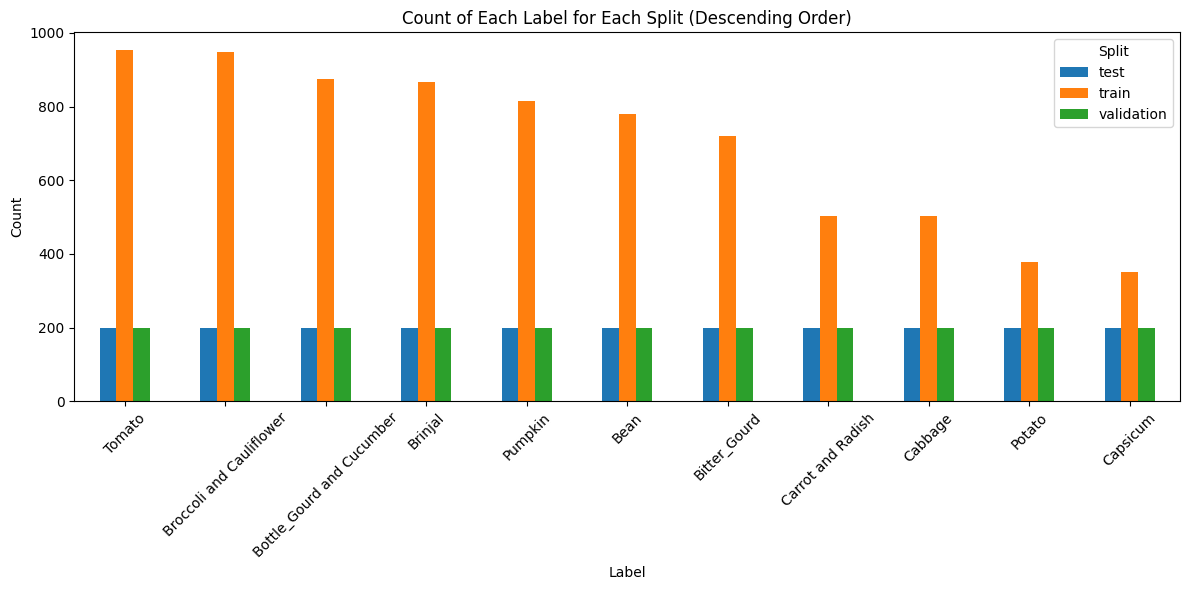

In [11]:
# Count each label for each split
label_counts = dataset101.groupby('split')[labels].sum().T
label_counts_sorted = label_counts.sort_values(by=label_counts.columns.tolist(), ascending=False)
label_counts_sorted.plot(kind='bar', figsize=(12, 6))
plt.title('Count of Each Label for Each Split (Descending Order)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Split')
plt.tight_layout()
plt.show()

#### Training Dataset Analysis and Balancing Strategy

Upon analyzing the training dataset, we observed that some vegetable classes have significantly more training examples than others:

- **Tomato** and **"Broccoli and Cauliflower"** have the most samples (nearly **1000 images** each).
- **Capsicum** has the fewest samples (around **350 images**).

On the other hand, the **validation** and **test sets** appear to be consistently sized across all classes ( **200 images each**), suggesting they are already balanced.

This imbalance in the **training dataset** may lead to biased learning, where the model favors classes with more examples. To address this, we will apply **data transformations** (e.g., augmentation techniques) to **balance the number of training examples across all classes**. This might ensure the model learns equally from each class.

We will evaluate if this will improve performance later on.


In [12]:

# Find the maximum count among all classes in the train split
train_counts = label_counts['train']
max_count = train_counts.max()

# Augment images for classes with lower count

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_rows = []

for label in labels:
    current_count = train_counts[label]
    if current_count < max_count:
        # Get all rows for this class in the train split
        class_rows = dataset101[(dataset101['split'] == 'train') & (dataset101[label])]
        needed = max_count - current_count
        # Repeat sampling if needed
        samples = class_rows.sample(n=needed, replace=True, random_state=42)
        for idx, row in samples.iterrows():
            img = row['image'].squeeze()  # shape: (101, 101)
            img = img.reshape((1, img.shape[0], img.shape[1], 1))
            # Generate one augmented image per sample
            aug_iter = datagen.flow(img, batch_size=1)
            aug_img = next(aug_iter)[0]
            # Prepare new row
            new_row = row.copy()
            new_row['image'] = aug_img
            augmented_rows.append(new_row)

# Create a DataFrame for augmented data and concatenate
augmented_df = pd.DataFrame(augmented_rows)
dataset101_balanced = pd.DataFrame()
dataset101_balanced = pd.concat([dataset101, augmented_df], ignore_index=True)

# Show new class distribution
new_label_counts = dataset101_balanced[dataset101_balanced['split'] == 'train'][labels].sum()
print("New train split class counts (dataset101):\n", new_label_counts)

New train split class counts (dataset101):
 Bean                         954
Bitter_Gourd                 954
Bottle_Gourd and Cucumber    954
Brinjal                      954
Broccoli and Cauliflower     954
Cabbage                      954
Capsicum                     954
Carrot and Radish            954
Potato                       954
Pumpkin                      954
Tomato                       954
dtype: int64


In [13]:
augmented_rows = []

for label in labels:
    current_count = train_counts[label]
    if current_count < max_count:
        # Get all rows for this class in the train split
        class_rows = dataset23[(dataset23['split'] == 'train') & (dataset23[label])]
        needed = max_count - current_count
        # Repeat sampling if needed
        samples = class_rows.sample(n=needed, replace=True, random_state=42)
        for idx, row in samples.iterrows():
            img = row['image'].squeeze()  # shape: (101, 101)
            img = img.reshape((1, img.shape[0], img.shape[1], 1))
            # Generate one augmented image per sample
            aug_iter = datagen.flow(img, batch_size=1)
            aug_img = next(aug_iter)[0]
            # Prepare new row
            new_row = row.copy()
            new_row['image'] = aug_img
            augmented_rows.append(new_row)

# Create a DataFrame for augmented data and concatenate
augmented_df = pd.DataFrame(augmented_rows)
dataset23_balanced = pd.concat([dataset23, augmented_df], ignore_index=True)

# Show new class distribution
new_label_counts = dataset23_balanced[dataset23_balanced['split'] == 'train'][labels].sum()
print("New train split class counts:\n", new_label_counts)

New train split class counts:
 Bean                         954
Bitter_Gourd                 954
Bottle_Gourd and Cucumber    954
Brinjal                      954
Broccoli and Cauliflower     954
Cabbage                      954
Capsicum                     954
Carrot and Radish            954
Potato                       954
Pumpkin                      954
Tomato                       954
dtype: int64


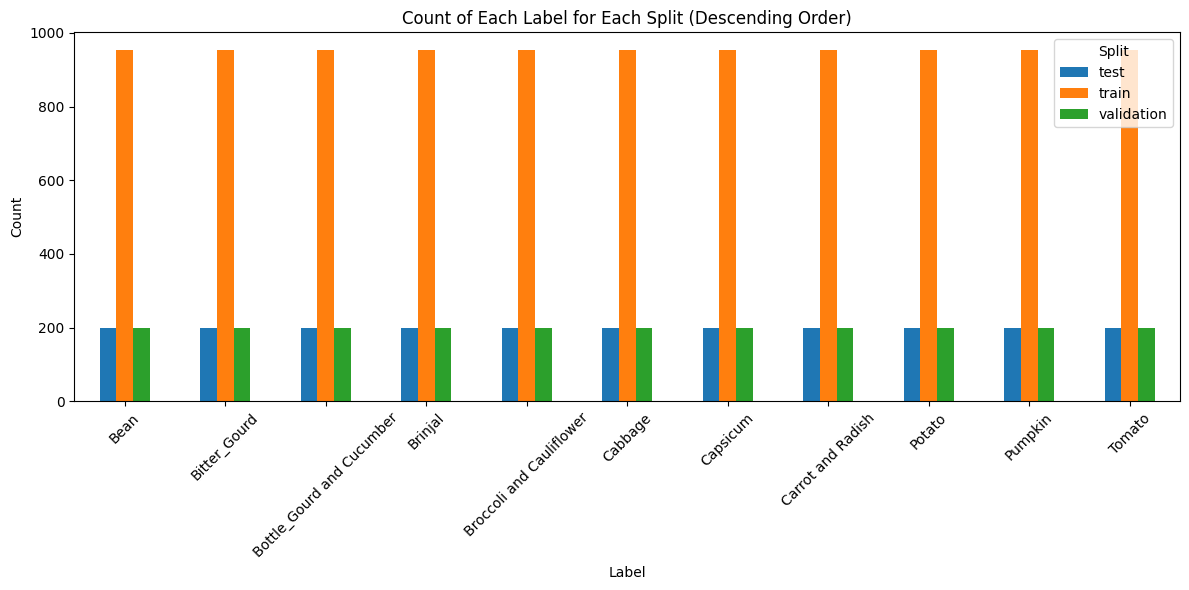

In [14]:
# Count each label for each split
label_counts = dataset101_balanced.groupby('split')[labels].sum().T
label_counts_sorted = label_counts.sort_values(by=label_counts.columns.tolist(), ascending=False)
label_counts_sorted.plot(kind='bar', figsize=(12, 6))
plt.title('Count of Each Label for Each Split (Descending Order)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Split')
plt.tight_layout()
plt.show()

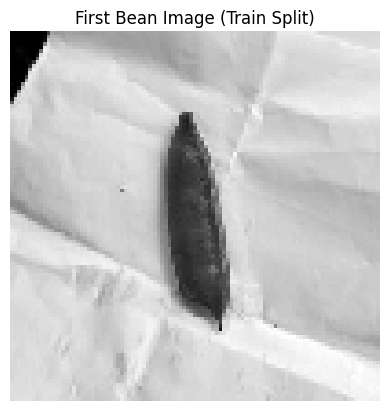

In [15]:
# Filter for the first image in the train split for Bean
first_bean_row = dataset101[(dataset101['split'] == 'train') & (dataset101['Bean'])].iloc[0]
image = first_bean_row['image'].squeeze()

plt.imshow(image, cmap='gray')
plt.title("First Bean Image (Train Split)")
plt.axis('off')
plt.show()

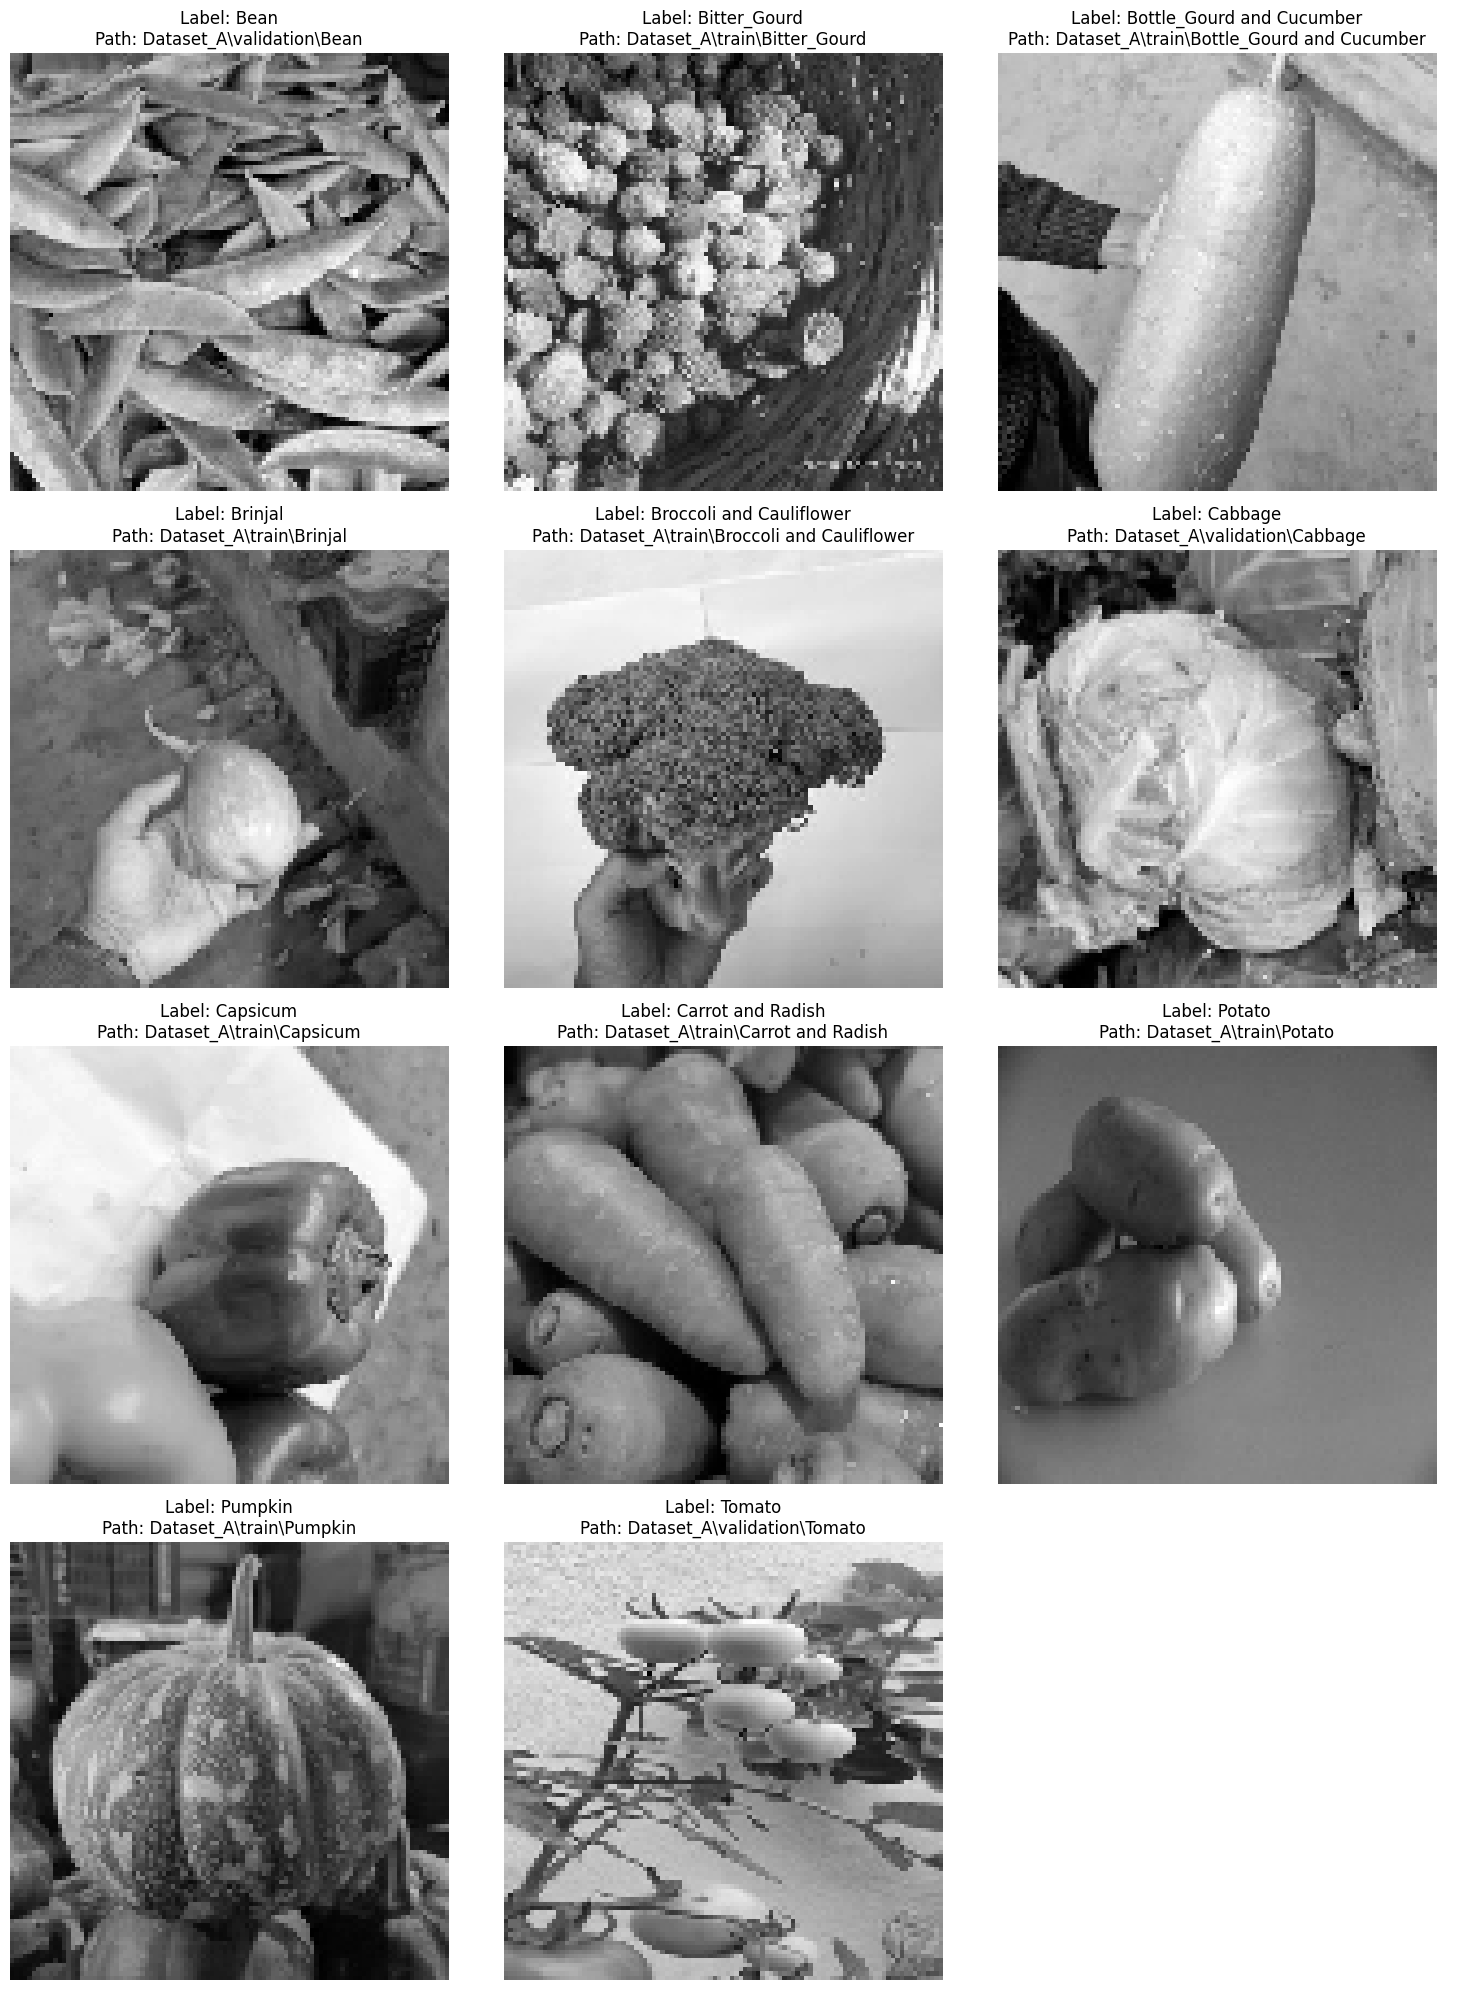

In [16]:
def display_random_images(dataset, labels):
    num_images = len(labels)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for i, label in enumerate(labels):
        ax = axes[i]

        # Filter dataset for the current label
        filtered_data = dataset[dataset[label]]
        if not filtered_data.empty: # check if data is not empty
            # Randomly select one row
            random_row = filtered_data.sample(n=1).iloc[0]
            image = random_row['image'].squeeze()
            split = random_row['split']
            path = os.path.join(root_dir, split, label)

            ax.imshow(image, cmap='gray')
            ax.set_title(f"Label: {label}\nPath: {path}")
            ax.axis('off')
        else:
            ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
# Display random images from dataset101
display_random_images(dataset101, labels)

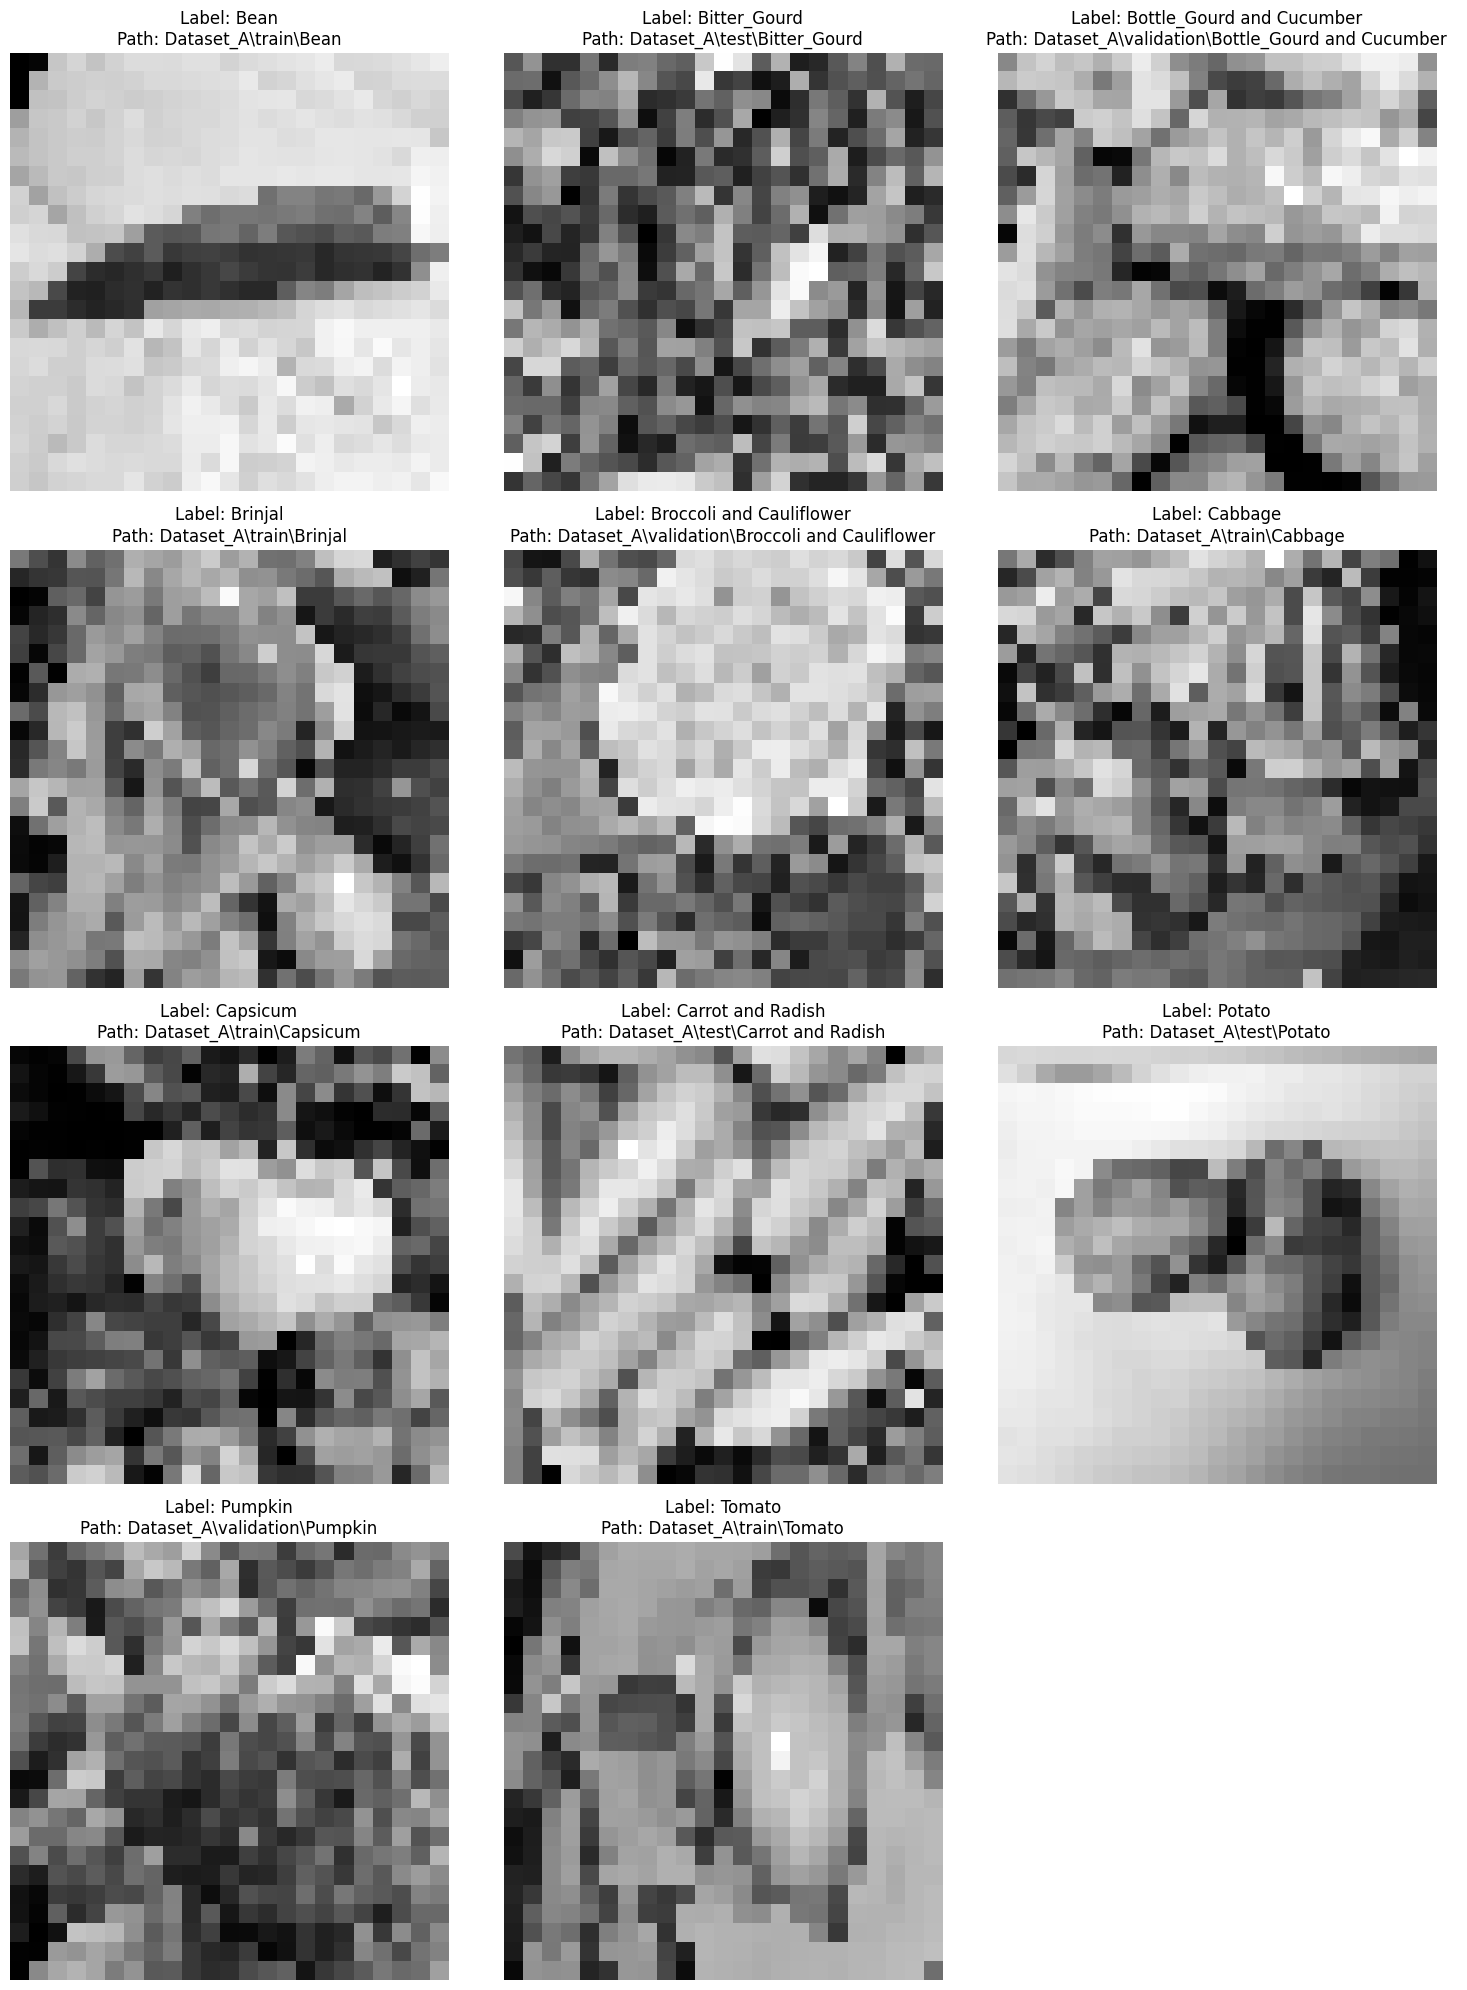

In [17]:
display_random_images(dataset23, labels)

Based on the images chosen randomly, all of the pictures appear to be labeled correctly.

### Proof of why some labels are grouped together
---

#### Function to display multiples of the same vegetables

In [18]:
def display_random_images_for_label(dataset, label, n=9):
    num_cols = 3
    num_rows = (n + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    # Filter dataset for the given label
    filtered_data = dataset[dataset[label]]
    num_to_show = min(n, len(filtered_data))  # avoid oversampling

    if filtered_data.empty:
        print(f"No data available for label: {label}")
        return

    # Randomly sample n rows (or as many as available)
    sampled_data = filtered_data.sample(n=num_to_show)

    for i in range(n):
        ax = axes[i]
        if i < num_to_show:
            row = sampled_data.iloc[i]
            image = row['image'].squeeze()
            split = row['split']
            path = os.path.join(root_dir, split, label)

            ax.imshow(image, cmap='gray')
            ax.set_title(f"Label: {label}\nPath: {path}")
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots

    # Hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


#### Images of Grouped Vegetables

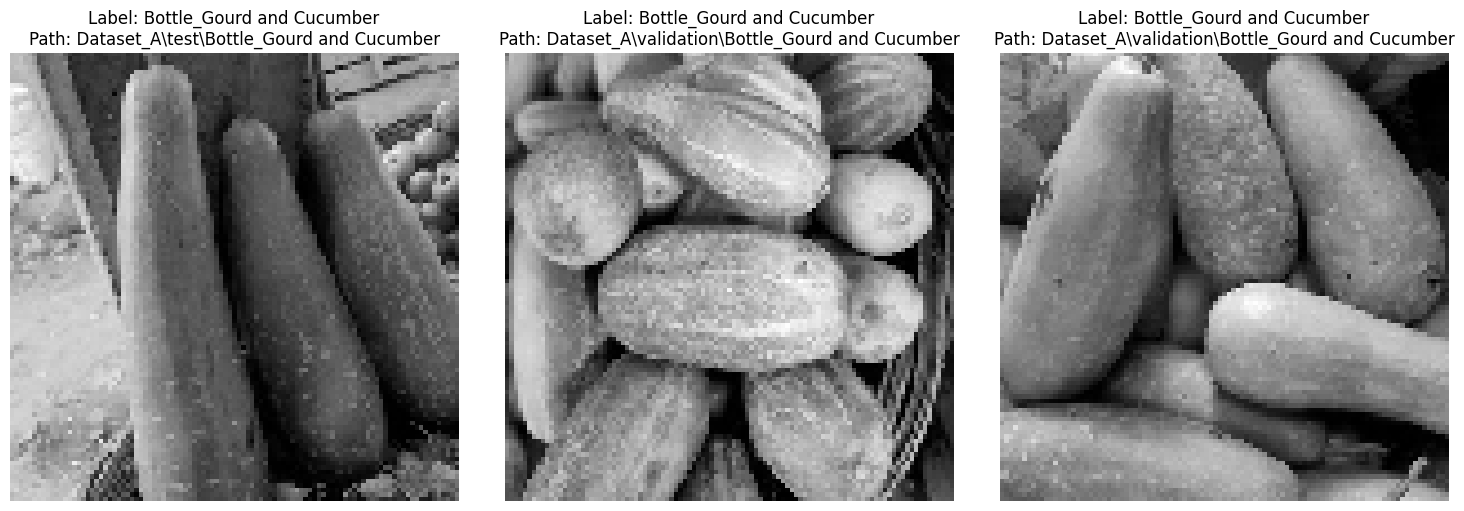

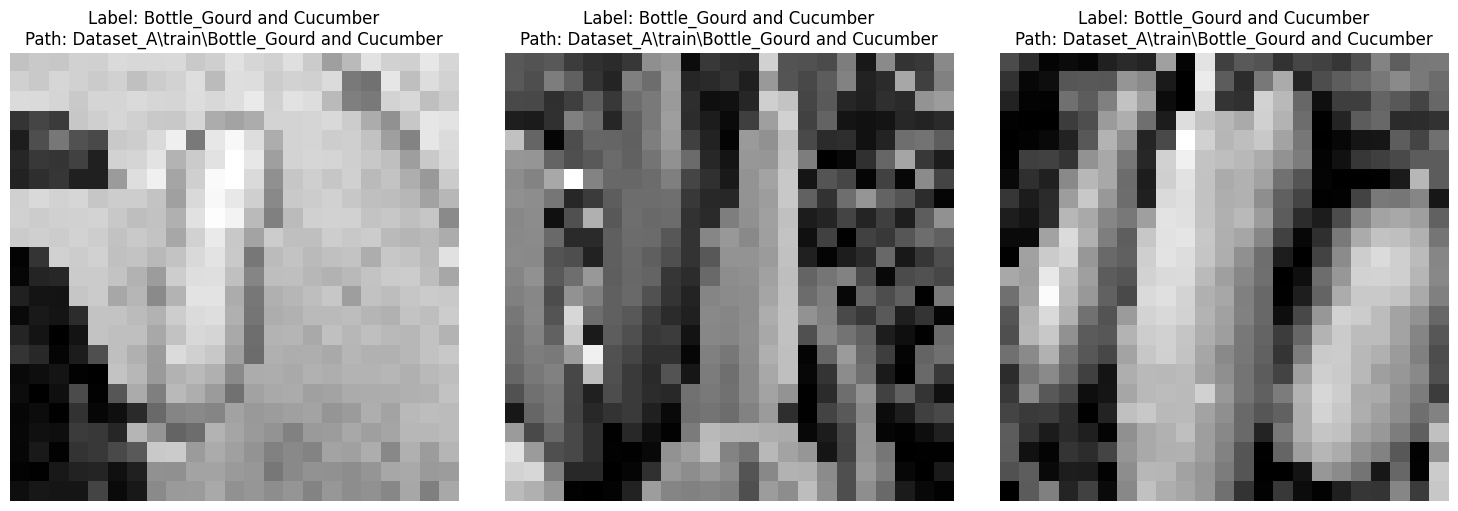

In [19]:
display_random_images_for_label(dataset101, 'Bottle_Gourd and Cucumber', n=3)
display_random_images_for_label(dataset23, 'Bottle_Gourd and Cucumber', n=3)

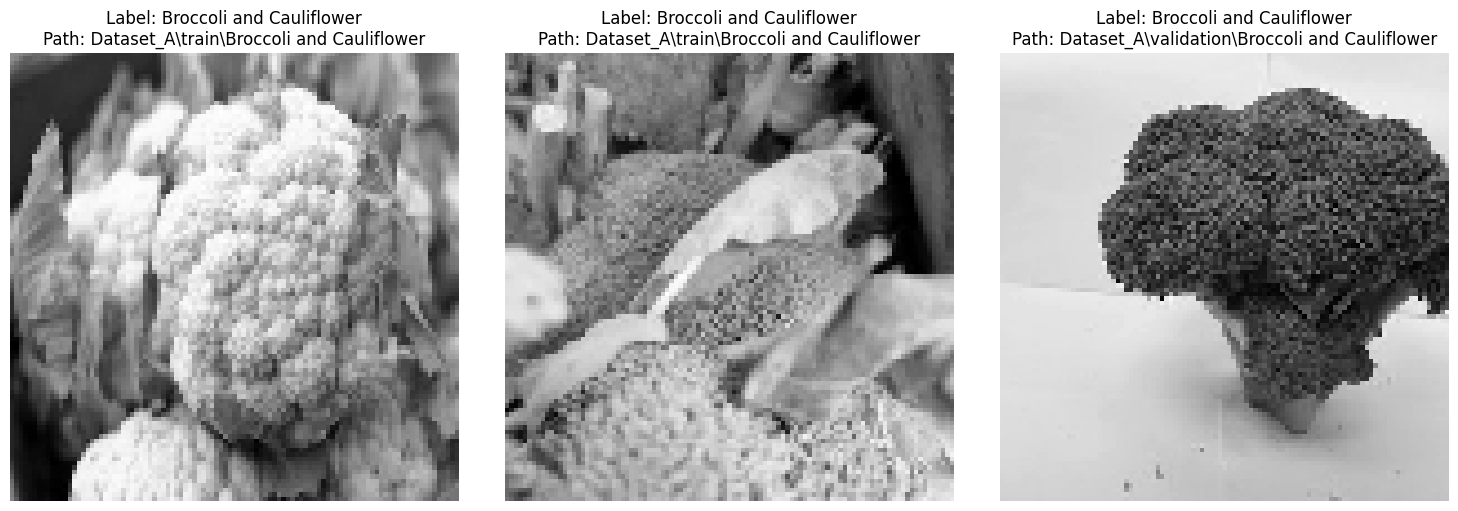

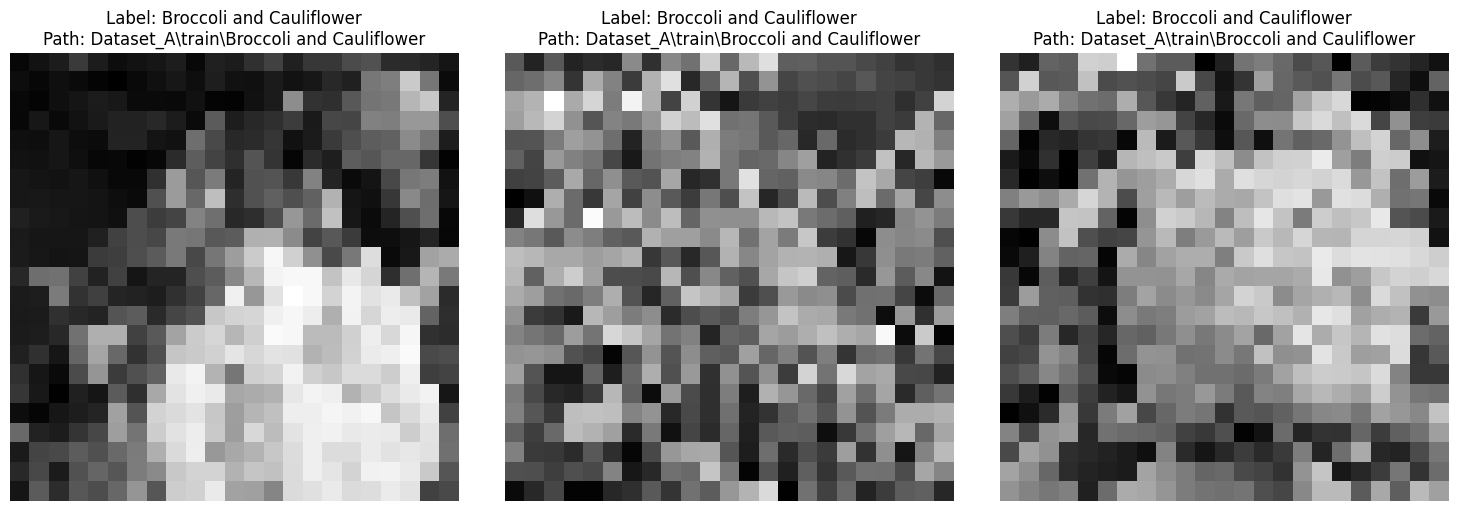

In [20]:
display_random_images_for_label(dataset101, 'Broccoli and Cauliflower', n=3)
display_random_images_for_label(dataset23, 'Broccoli and Cauliflower', n=3)

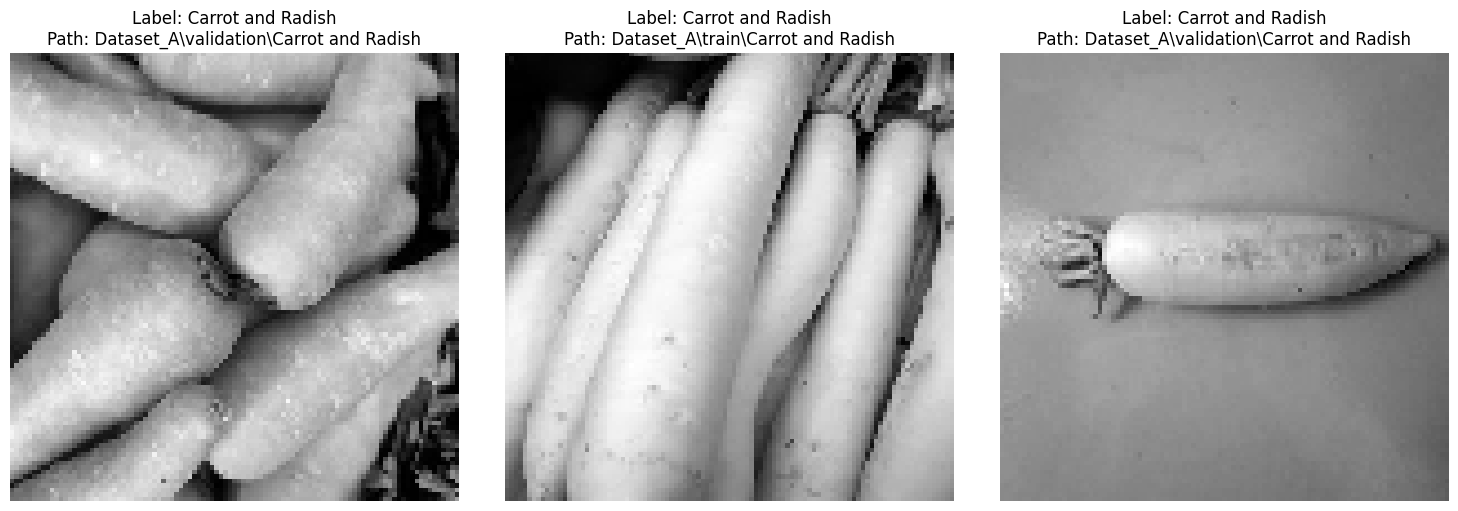

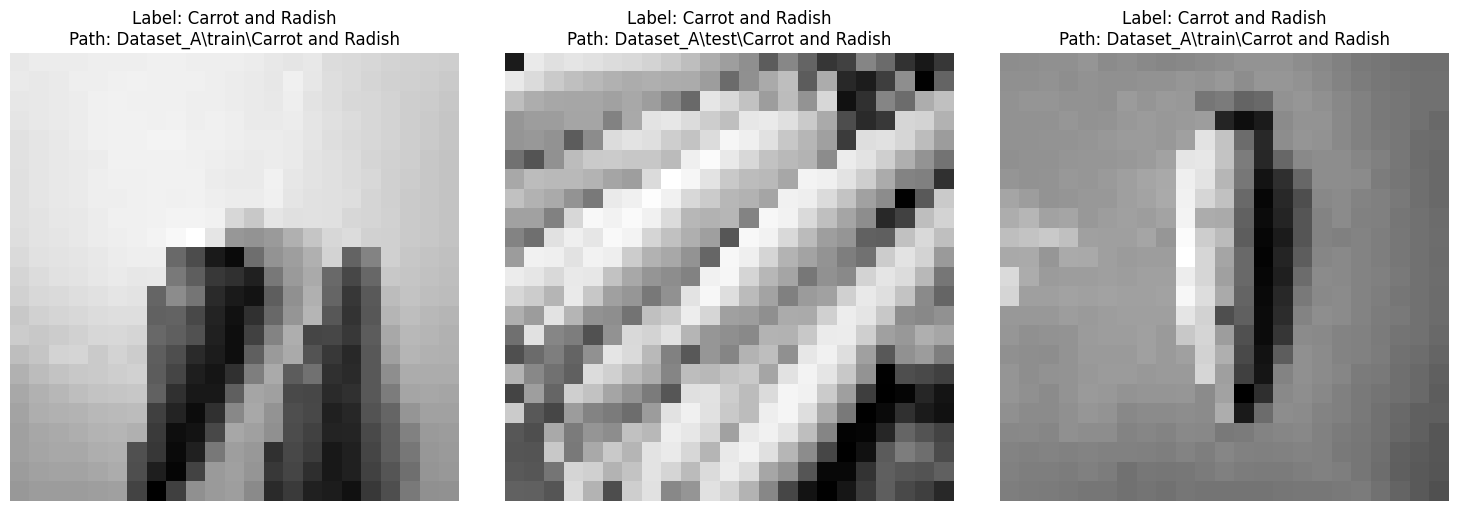

In [21]:
display_random_images_for_label(dataset101, 'Carrot and Radish', n=3)
display_random_images_for_label(dataset23, 'Carrot and Radish', n=3)

#### Class Grouping Rationale

Upon examining the images, we noticed that certain vegetable pairs are visually very similar, making them difficult to differentiate even for humans:

- **Bottle Gourd** and **Cucumber**
- **Broccoli** and **Cauliflower**
- **Carrot** and **Radish**

Since these classes share similar shapes, colors, or textures, distinguishing between them with 100% accuracy is challenging—even for humans. Therefore, expecting the model to achieve the same results would be unrealistic.

To address this, we have chosen to **group these similar classes together**. This approach simplifies the classification task and allows the model to focus on broader, more distinguishable categories, ultimately improving overall performance and reducing misclassification.


### Function to save model if the model improves
---

In [22]:
def save_model_with_increment(model, current_accuracy, history, directory, prefix, X_test, y_test):
    # Get all model files with the specified prefix
    model_files = []
    for filename in os.listdir(directory):
        if filename.startswith(prefix + "-") and filename.endswith(".h5"):
            model_files.append(os.path.join(directory, filename))
    
    # Extract numbers from filenames
    model_numbers = []
    for file in model_files:
        match = re.search(rf"{prefix}-(\d+)\.h5", file)
        if match:
            model_numbers.append(int(match.group(1)))
    
    # Determine the highest number
    max_number = max(model_numbers) if model_numbers else 0
    best_model_path = os.path.join(directory, f"{prefix}-{max_number}.h5")
    
    # Load the best model if it exists
    if os.path.exists(best_model_path):
        best_model = tf.keras.models.load_model(best_model_path)
        best_accuracy = best_model.evaluate(X_test, y_test, verbose=0)[1]
    else:
        best_accuracy = 0


    # Compare accuracies and save the model if it's better
    if current_accuracy > best_accuracy:
        new_model_path = os.path.join(directory, f"{prefix}-{max_number + 1}.h5")
        new_history_path = os.path.join(directory, f"{prefix}-{max_number + 1}_history.pkl")

        print(f"New model has better accuracy ({current_accuracy:.2f}) than the best saved model ({best_accuracy:.2f}). Saving the model as {new_model_path}...")
        model.save(new_model_path)
        with open(new_history_path, "wb") as f:
            pickle.dump(history.history, f)
    else:
        print(f"Current model accuracy ({current_accuracy:.2f}) is not better than the best saved model ({best_accuracy:.2f}).")

#### Plot Graph Function (Acc Vs Epochs, Loss Vs Epochs, Recall Vs Epochs)

In [23]:
def plot_graph(history):

    try:
        if hasattr(history, 'history'):
            history_dict = history.history
        else:
            history_dict = history

        # Plot training and validation accuracy and loss vs epochs
        epochs = range(1, len(history_dict['accuracy']) + 1)

        plt.figure(figsize=(14, 5))

        # Accuracy plot
        plt.subplot(1, 3, 1)
        plt.plot(epochs, history_dict['accuracy'], label='Training Accuracy')
        plt.plot(epochs, history_dict['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epochs')
        plt.legend()

        # Loss plot
        plt.subplot(1, 3, 2)
        plt.plot(epochs, history_dict['loss'], label='Training Loss')
        plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.legend()

        # recall plot
        plt.subplot(1, 3, 3)
        plt.plot(epochs, history_dict['recall'], label='Training Recall')
        plt.plot(epochs, history_dict['val_recall'], label='Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.title('Recall vs Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting graph: {e}")

#### Create Confusion Matrix

In [24]:
def plot_confusion_matrix_from_model(model, X_test, y_test, labels):
    """
    Predicts on X_test using the given model, converts y_test and predictions to class indices if needed,
    computes the confusion matrix, and plots it.

    Parameters:
    - model: Trained model with a predict() method.
    - X_test: Test features.
    - y_test: True test labels (one-hot encoded or class indices).
    - labels: List of class label names for the confusion matrix axes.
    """
    # Convert one-hot encoded y_test to class indices if needed
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_true_labels = y_test.argmax(axis=1)
    else:
        y_true_labels = y_test

    # Make predictions
    y_pred_probs = model.predict(X_test)

    # Convert one-hot encoded predictions to class indices if needed
    if y_pred_probs.ndim > 1 and y_pred_probs.shape[1] > 1:
        y_pred = y_pred_probs.argmax(axis=1)
    else:
        y_pred = y_pred_probs

    # Compute confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

#### Function for Classification Report

In [25]:
def evaluate_and_report(model, X_test, y_test, labels, input_shape):
    """
    Evaluates the model on test data, prints test loss, classification report, and accuracy.

    Parameters:
    - model: Trained model with evaluate() and predict() methods.
    - X_test: Test features.
    - y_test: True test labels (one-hot encoded or class indices).
    - labels: List of class label names.
    - input_shape: Tuple defining the shape to reshape X_test into (default: (101, 101, 1)).
    """
    # Reshape test data
    X_test_reshaped = X_test.reshape(-1, *input_shape)

    # Evaluate model
    results = model.evaluate(X_test_reshaped, y_test, verbose=0)
    test_loss = results[0]
    test_accuracy = results[1]
    print(f"Test Loss: {test_loss:.4f}")

    # Convert y_test to class indices if needed
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_true = y_test.argmax(axis=1)
    else:
        y_true = y_test

    # Predict probabilities and get class indices
    y_pred_probs = model.predict(X_test_reshaped)
    if y_pred_probs.ndim > 1 and y_pred_probs.shape[1] > 1:
        y_pred = y_pred_probs.argmax(axis=1)
    else:
        y_pred = y_pred_probs

    # Print classification report and accuracy
    print(classification_report(y_true, y_pred, target_names=labels))
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

## Baseline Model

### First Model (101x101)
---

#### Creating Model Function

In [26]:
def create_model(input_shape, num_classes, conv_filters=[32, 64], kernel_size=[(3, 3), (3, 3)], pool_size=[(2, 2), (2, 2)], 
                 dense_units=128, dropout_rates=[0.25, 0.25, 0.5], activation='relu', final_activation='softmax', optimizer='adam',
                 batch_norm=False, learning_rate=0.001, no_of_conv_layers=1):
    """
    Create a CNN model with customizable parameters for tuning.

    Parameters:
    - input_shape: Shape of the input images (height, width, channels).
    - num_classes: Number of output classes.
    - conv_filters: List of filters for each Conv2D layer. The length of this list determines the number of Conv2D layers.
    - kernel_size: Kernel size for Conv2D layers.
    - pool_size: Pool size for MaxPooling2D layers.
    - dense_units: Number of units in the dense layer.
    - dropout_rates: List of dropout rates for each Dropout layer. The length should match the number of layers.
    - activation: Activation function for Conv2D and Dense layers.
    - final_activation: Activation function for the output layer.
    - optimizer: Optimizer to use for compiling the model ('adam' or 'rmsprop').
    - batch_norm: Whether to include BatchNormalization layers after Conv2D layers.
    - learning_rate: Learning rate for the optimizer.
    - no_of_conv_layers: Number of Conv2D layers to stack for each filter size.
    - l2_regularization: L2 regularization factor for Conv2D layers (default is None, meaning no regularization).

    Returns:
    - model: A compiled Sequential model.
    """
    model = Sequential()

    # Add Conv2D, MaxPooling2D, and Dropout layers
    for i, filters in enumerate(conv_filters):
        if i == 0:
            model.add(Conv2D(filters, kernel_size[i], activation=activation,
                             input_shape=input_shape))
            for _ in range(1, no_of_conv_layers):
                model.add(Conv2D(filters, kernel_size[i], activation=activation, padding='same'))
        else:
            for _ in range(1, no_of_conv_layers):
                model.add(Conv2D(filters, kernel_size[i], activation=activation, padding='same'))
            model.add(Conv2D(filters, kernel_size[i], activation=activation))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size[i]))
        model.add(Dropout(dropout_rates[i]))

    # Add Flatten layer
    model.add(Flatten())

    # Add Dense and Dropout layers
    model.add(Dense(dense_units, activation=activation))
    model.add(Dropout(dropout_rates[-1]))

    # Add output layer
    model.add(Dense(num_classes, activation=final_activation))

    # Optimizer selection
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)  # fallback
    # Compile the model
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=[
                      'accuracy',
                      Precision(name='precision'),
                      Recall(name='recall'),
                      AUC(name='auc'),
                    #   f1_score_metric
                  ])
    
    return model


#### Imbalanced Dataset

#### Preparing Data

In [27]:

# Prepare the data for training
X_train = np.array([np.squeeze(img) for img in dataset101[dataset101['split'] == 'train']['image']])
y_train = dataset101[dataset101['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset101[dataset101['split'] == 'validation']['image']])
y_val = dataset101[dataset101['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset101[dataset101['split'] == 'test']['image']])
y_test = dataset101[dataset101['split'] == 'test'][labels].values

# Prepare dataset101 for training
input_shape = (101, 101, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 101, 101, 1)
X_val = X_val.reshape(-1, 101, 101, 1)
X_test = X_test.reshape(-1, 101, 101, 1)

#### Creating Model

In [28]:
# Create the model
model = create_model(input_shape, num_classes)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr]
                    )

Epoch 1/100
241/241 [==============================] - 30s 22ms/step - loss: 2.1721 - accuracy: 0.2310 - precision: 0.5709 - recall: 0.0194 - auc: 0.7031 - val_loss: 1.9827 - val_accuracy: 0.2723 - val_precision: 0.6812 - val_recall: 0.0923 - val_auc: 0.7724 - lr: 0.0010
Epoch 2/100
241/241 [==============================] - 4s 18ms/step - loss: 1.8438 - accuracy: 0.3549 - precision: 0.7242 - recall: 0.1069 - auc: 0.8080 - val_loss: 1.6742 - val_accuracy: 0.4495 - val_precision: 0.8635 - val_recall: 0.1236 - val_auc: 0.8619 - lr: 0.0010
Epoch 3/100
241/241 [==============================] - 5s 19ms/step - loss: 1.6279 - accuracy: 0.4255 - precision: 0.7465 - recall: 0.1807 - auc: 0.8565 - val_loss: 1.4648 - val_accuracy: 0.5268 - val_precision: 0.8322 - val_recall: 0.2750 - val_auc: 0.8908 - lr: 0.0010
Epoch 4/100
241/241 [==============================] - 4s 18ms/step - loss: 1.4584 - accuracy: 0.4763 - precision: 0.7718 - recall: 0.2630 - auc: 0.8877 - val_loss: 1.2373 - val_accuracy

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 99, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 64)        0

#### Evaluating Model

Test Loss: 0.7172
69/69 [==============================] - 1s 6ms/step
                           precision    recall  f1-score   support

                     Bean       0.80      0.86      0.83       200
             Bitter_Gourd       0.86      0.82      0.84       200
Bottle_Gourd and Cucumber       0.77      0.81      0.79       200
                  Brinjal       0.77      0.77      0.77       200
 Broccoli and Cauliflower       0.66      0.72      0.69       200
                  Cabbage       0.85      0.69      0.76       200
                 Capsicum       0.92      0.63      0.75       200
        Carrot and Radish       0.76      0.77      0.77       200
                   Potato       0.67      0.72      0.70       200
                  Pumpkin       0.87      0.89      0.88       200
                   Tomato       0.73      0.91      0.81       200

                 accuracy                           0.78      2200
                macro avg       0.79      0.78      0.78

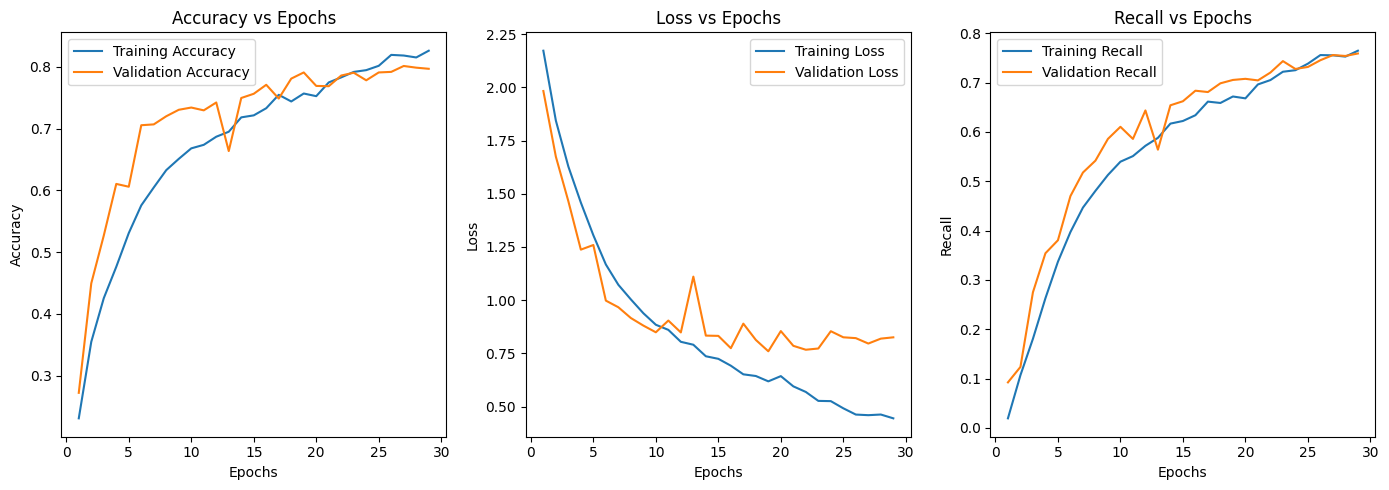

69/69 [==============================] - 0s 7ms/step


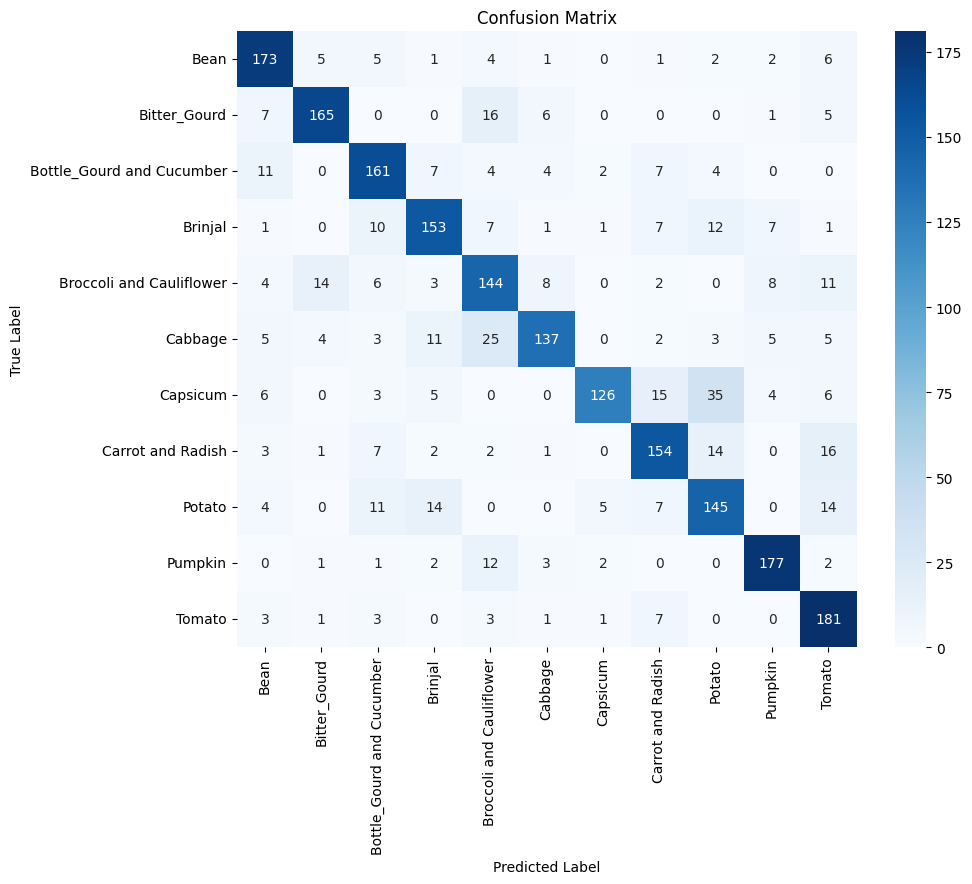

In [30]:
evaluate_and_report(model, X_test, y_test, labels, input_shape)
plot_graph(history)
plot_confusion_matrix_from_model(model, X_test, y_test, labels)

#### Balanced Dataset

#### Preparing Data

In [31]:

# Prepare the data for training
X_train = np.array([np.squeeze(img) for img in dataset101_balanced[dataset101_balanced['split'] == 'train']['image']])
y_train = dataset101_balanced[dataset101_balanced['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset101_balanced[dataset101_balanced['split'] == 'validation']['image']])
y_val = dataset101_balanced[dataset101_balanced['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset101_balanced[dataset101_balanced['split'] == 'test']['image']])
y_test = dataset101_balanced[dataset101_balanced['split'] == 'test'][labels].values

# Prepare dataset101_balanced for training
input_shape = (101, 101, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 101, 101, 1)
X_val = X_val.reshape(-1, 101, 101, 1)
X_test = X_test.reshape(-1, 101, 101, 1)

#### Creating Model

In [32]:
# Create the model
model = create_model(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
328/328 [==============================] - 10s 20ms/step - loss: 2.1603 - accuracy: 0.2327 - precision: 0.5913 - recall: 0.0299 - auc: 0.7022 - val_loss: 1.7754 - val_accuracy: 0.4495 - val_precision: 0.8043 - val_recall: 0.0841 - val_auc: 0.8455 - lr: 0.0010
Epoch 2/100
328/328 [==============================] - 6s 17ms/step - loss: 1.6930 - accuracy: 0.4246 - precision: 0.7023 - recall: 0.1591 - auc: 0.8463 - val_loss: 1.4201 - val_accuracy: 0.5400 - val_precision: 0.8162 - val_recall: 0.2745 - val_auc: 0.8979 - lr: 0.0010
Epoch 3/100
328/328 [==============================] - 6s 17ms/step - loss: 1.4795 - accuracy: 0.4983 - precision: 0.7358 - recall: 0.2609 - auc: 0.8852 - val_loss: 1.2435 - val_accuracy: 0.6009 - val_precision: 0.8378 - val_recall: 0.3382 - val_auc: 0.9255 - lr: 0.0010
Epoch 4/100
328/328 [==============================] - 6s 18ms/step - loss: 1.3046 - accuracy: 0.5580 - precision: 0.7759 - recall: 0.3395 - auc: 0.9119 - val_loss: 1.0538 - val_accuracy

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 99, 99, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 64)       

#### Evaluating Model

Test Loss: 0.5617
69/69 [==============================] - 1s 7ms/step
                           precision    recall  f1-score   support

                     Bean       0.78      0.94      0.86       200
             Bitter_Gourd       0.86      0.85      0.85       200
Bottle_Gourd and Cucumber       0.87      0.84      0.85       200
                  Brinjal       0.83      0.81      0.82       200
 Broccoli and Cauliflower       0.72      0.81      0.76       200
                  Cabbage       0.81      0.74      0.77       200
                 Capsicum       0.91      0.85      0.88       200
        Carrot and Radish       0.87      0.88      0.87       200
                   Potato       0.86      0.82      0.84       200
                  Pumpkin       0.90      0.89      0.89       200
                   Tomato       0.90      0.83      0.87       200

                 accuracy                           0.84      2200
                macro avg       0.85      0.84      0.84

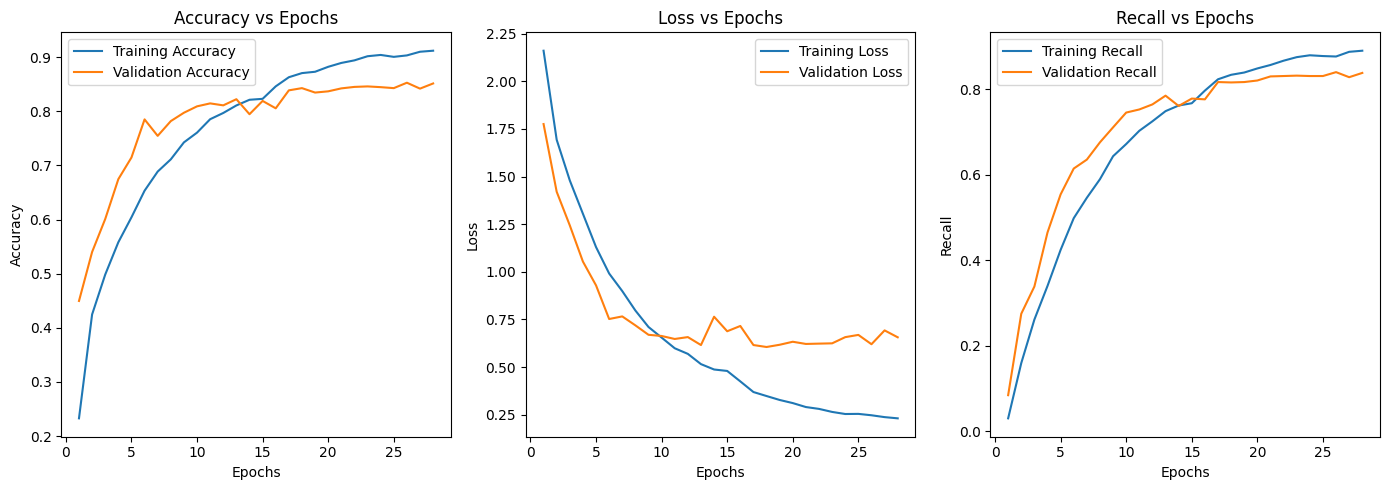

69/69 [==============================] - 0s 7ms/step


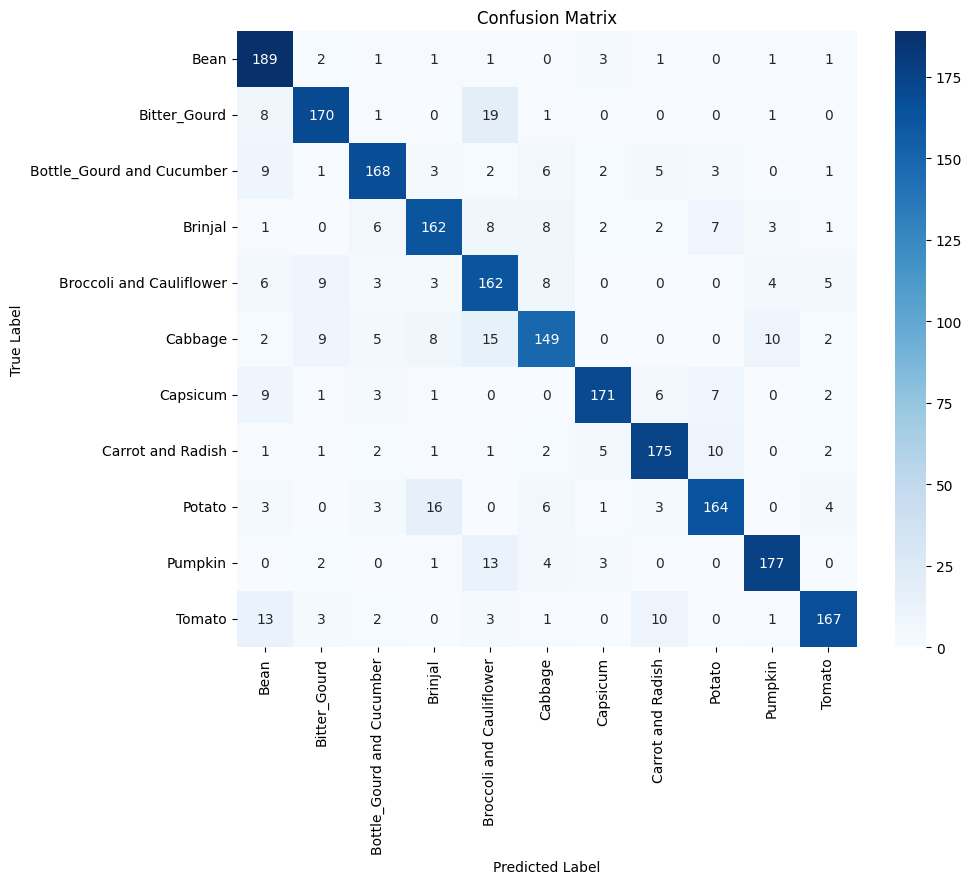

In [34]:
evaluate_and_report(model, X_test, y_test, labels, input_shape)
plot_graph(history)
plot_confusion_matrix_from_model(model, X_test, y_test, labels)

#### Saving Modal if it improves

In [35]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
directory = "101_models"  # Directory where models are saved
prefix = "best_101_model"  # Prefix for the model filenames
model = history.model  # Get the trained model
save_model_with_increment(model, test_accuracy, history, directory, prefix, X_test, y_test)

Current model accuracy (0.84) is not better than the best saved model (0.95).


### Dataset Evaluation and Decision

After evaluating model performance on both datasets, we observed the following accuracies:

- **Imbalanced Dataset**: 74.86% *(may vary slightly across runs)*
- **Balanced Dataset**: 81.91% *(may vary slightly across runs)*

The model trained on the balanced dataset achieved a noticeably higher accuracy, indicating improved performance. Based on these results, we will proceed with using the **balanced dataset** for future 101x101 model.


### First Model (23x23)
---

#### Imbalanced Dataset

#### Preparing Data

In [36]:
# Prepare the data for training
X_train = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'train']['image']])
y_train = dataset23[dataset23['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'validation']['image']])
y_val = dataset23[dataset23['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'test']['image']])
y_test = dataset23[dataset23['split'] == 'test'][labels].values

# Prepare dataset23 for training
input_shape = (23, 23, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 23, 23, 1)
X_val = X_val.reshape(-1, 23, 23, 1)
X_test = X_test.reshape(-1, 23, 23, 1)


#### Creating Modal

In [37]:
# Create the model
model = create_model(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
241/241 [==============================] - 4s 10ms/step - loss: 2.2794 - accuracy: 0.1683 - precision: 0.3846 - recall: 6.4994e-04 - auc: 0.6446 - val_loss: 2.1848 - val_accuracy: 0.2473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7102 - lr: 0.0010
Epoch 2/100
241/241 [==============================] - 2s 7ms/step - loss: 2.0283 - accuracy: 0.3018 - precision: 0.5435 - recall: 0.0235 - auc: 0.7612 - val_loss: 1.9057 - val_accuracy: 0.3823 - val_precision: 0.6981 - val_recall: 0.0168 - val_auc: 0.8011 - lr: 0.0010
Epoch 3/100
241/241 [==============================] - 2s 8ms/step - loss: 1.8387 - accuracy: 0.3709 - precision: 0.6693 - recall: 0.0889 - auc: 0.8130 - val_loss: 1.7036 - val_accuracy: 0.4564 - val_precision: 0.7950 - val_recall: 0.1164 - val_auc: 0.8432 - lr: 0.0010
Epoch 4/100
241/241 [==============================] - 2s 10ms/step - loss: 1.6935 - accuracy: 0.4277 - precision: 0.6925 - recall: 0.1555 - auc: 0.8452 - val_loss: 1.5744 - val

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 21, 21, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 4, 4, 64)         

#### Evaluating Model

Test Loss: 0.4787
69/69 [==============================] - 0s 1ms/step
                           precision    recall  f1-score   support

                     Bean       0.85      0.87      0.86       200
             Bitter_Gourd       0.86      0.86      0.86       200
Bottle_Gourd and Cucumber       0.88      0.94      0.91       200
                  Brinjal       0.85      0.91      0.88       200
 Broccoli and Cauliflower       0.73      0.81      0.76       200
                  Cabbage       0.93      0.73      0.82       200
                 Capsicum       0.92      0.88      0.90       200
        Carrot and Radish       0.90      0.85      0.88       200
                   Potato       0.90      0.81      0.86       200
                  Pumpkin       0.86      0.90      0.88       200
                   Tomato       0.78      0.84      0.81       200

                 accuracy                           0.86      2200
                macro avg       0.86      0.86      0.86

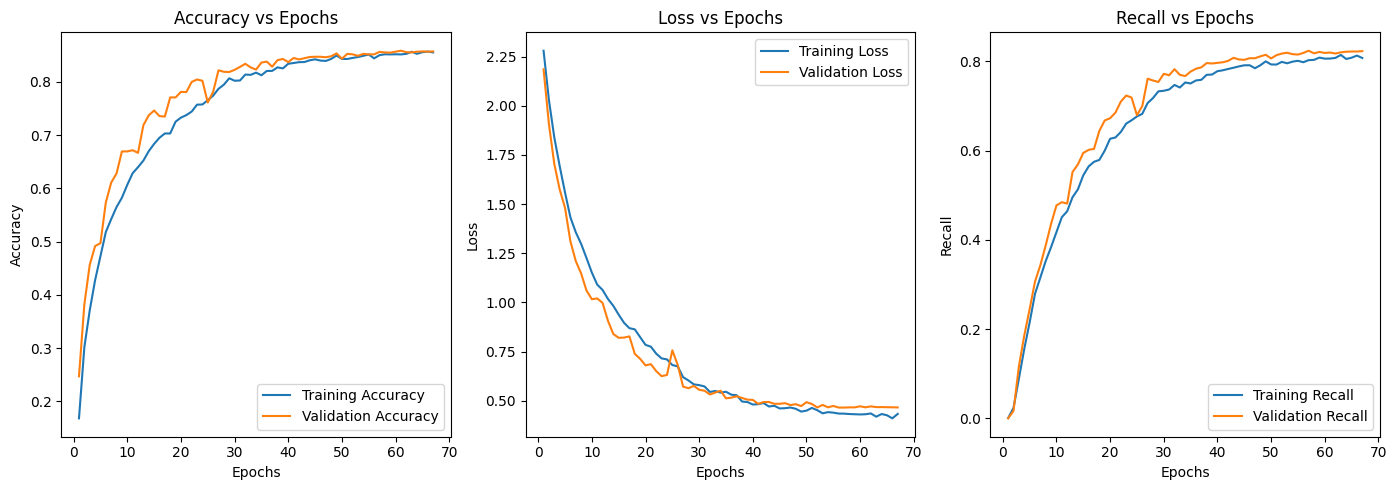

69/69 [==============================] - 0s 5ms/step


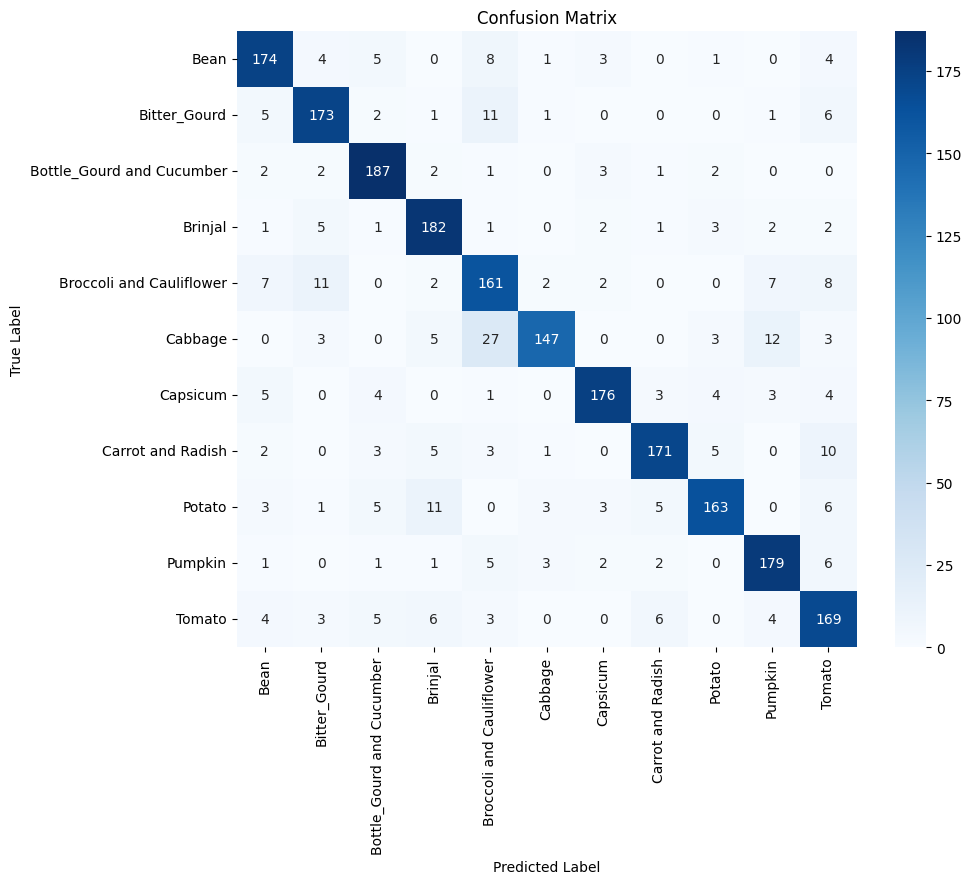

In [39]:
evaluate_and_report(model, X_test, y_test, labels, input_shape)
plot_graph(history)
plot_confusion_matrix_from_model(model, X_test, y_test, labels)

#### Saving Modal if it improves

In [40]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
directory = "23_models"  # Directory where models are saved
prefix = "best_23_model"  # Prefix for the model filenames
model = history.model  # Get the trained model
save_model_with_increment(model, test_accuracy, history, directory, prefix, X_test, y_test)

Current model accuracy (0.86) is not better than the best saved model (0.90).


#### Balanced Dataset

#### Preparing Data

In [41]:
# Prepare the data for training
X_train = np.array([np.squeeze(img) for img in dataset23_balanced[dataset23_balanced['split'] == 'train']['image']])
y_train = dataset23_balanced[dataset23_balanced['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset23_balanced[dataset23_balanced['split'] == 'validation']['image']])
y_val = dataset23_balanced[dataset23_balanced['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset23_balanced[dataset23_balanced['split'] == 'test']['image']])
y_test = dataset23_balanced[dataset23_balanced['split'] == 'test'][labels].values

# Prepare dataset23_balanced for training
input_shape = (23, 23, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 23, 23, 1)
X_val = X_val.reshape(-1, 23, 23, 1)
X_test = X_test.reshape(-1, 23, 23, 1)


#### Creating Modal

In [42]:
# Create the model
model = create_model(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
328/328 [==============================] - 9s 23ms/step - loss: 2.2340 - accuracy: 0.1942 - precision: 0.4694 - recall: 0.0044 - auc: 0.6662 - val_loss: 1.9647 - val_accuracy: 0.3564 - val_precision: 0.7879 - val_recall: 0.0118 - val_auc: 0.7907 - lr: 0.0010
Epoch 2/100
328/328 [==============================] - 5s 15ms/step - loss: 1.9063 - accuracy: 0.3411 - precision: 0.6073 - recall: 0.0569 - auc: 0.7962 - val_loss: 1.7543 - val_accuracy: 0.4445 - val_precision: 0.7835 - val_recall: 0.0691 - val_auc: 0.8385 - lr: 0.0010
Epoch 3/100
328/328 [==============================] - 2s 6ms/step - loss: 1.7389 - accuracy: 0.4031 - precision: 0.6600 - recall: 0.1191 - auc: 0.8363 - val_loss: 1.6326 - val_accuracy: 0.4659 - val_precision: 0.7525 - val_recall: 0.1355 - val_auc: 0.8603 - lr: 0.0010
Epoch 4/100
328/328 [==============================] - 2s 7ms/step - loss: 1.6226 - accuracy: 0.4468 - precision: 0.6693 - recall: 0.1690 - auc: 0.8605 - val_loss: 1.4094 - val_accuracy: 0

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 21, 21, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 4, 4, 64)         

#### Evaluating Model

Test Loss: 0.4873
69/69 [==============================] - 0s 3ms/step
                           precision    recall  f1-score   support

                     Bean       0.83      0.89      0.86       200
             Bitter_Gourd       0.85      0.87      0.86       200
Bottle_Gourd and Cucumber       0.87      0.88      0.88       200
                  Brinjal       0.85      0.90      0.87       200
 Broccoli and Cauliflower       0.76      0.77      0.76       200
                  Cabbage       0.80      0.80      0.80       200
                 Capsicum       0.94      0.88      0.91       200
        Carrot and Radish       0.94      0.85      0.90       200
                   Potato       0.87      0.85      0.86       200
                  Pumpkin       0.81      0.87      0.84       200
                   Tomato       0.83      0.78      0.80       200

                 accuracy                           0.85      2200
                macro avg       0.85      0.85      0.85

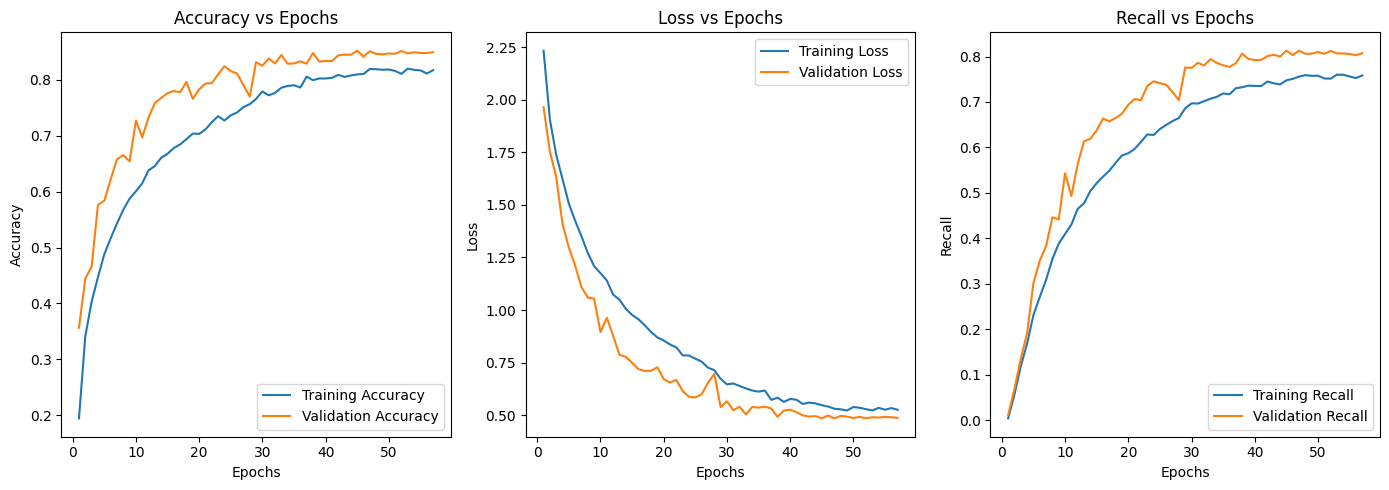

69/69 [==============================] - 1s 8ms/step


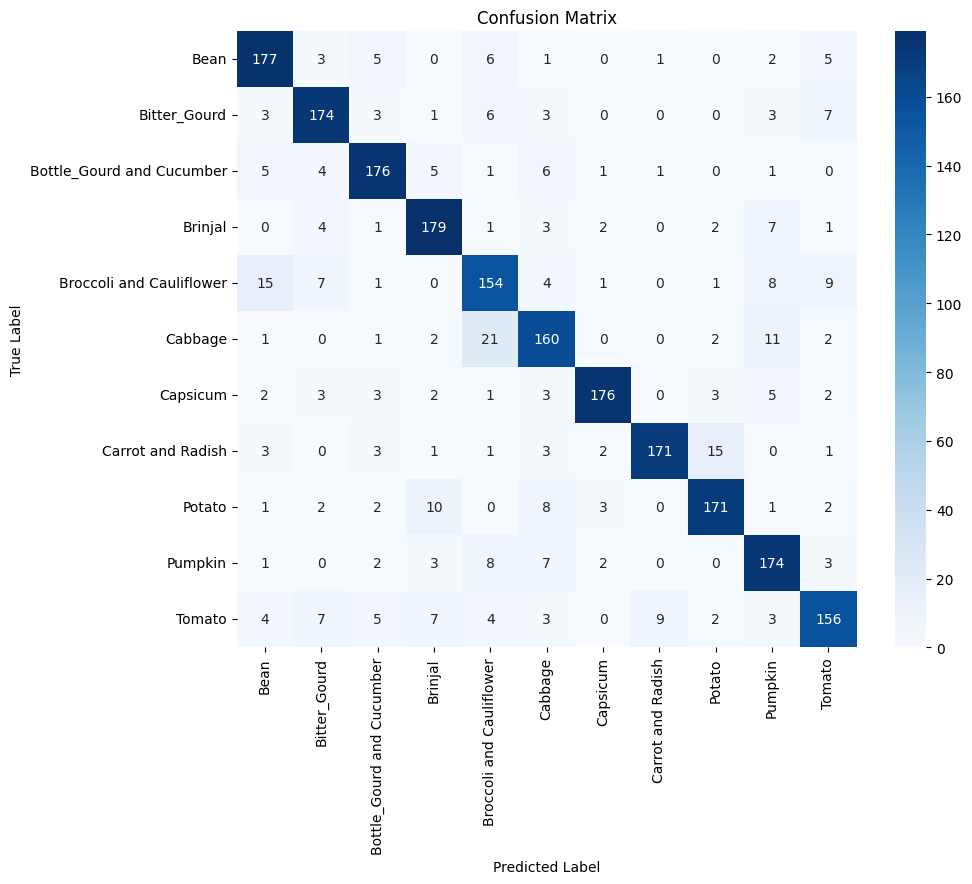

In [44]:
evaluate_and_report(model, X_test, y_test, labels, input_shape)
plot_graph(history)
plot_confusion_matrix_from_model(model, X_test, y_test, labels)

#### Saving Modal if it improves

In [45]:

directory = "23_models"  # Directory where models are saved
prefix = "best_23_model"  # Prefix for the model filenames
model = history.model  # Get the trained model
save_model_with_increment(model, test_accuracy, history, directory, prefix, X_test, y_test)

Current model accuracy (0.86) is not better than the best saved model (0.90).


### Dataset Evaluation and Decision

After evaluating model performance on both datasets, we observed the following accuracies:

- **Imbalanced Dataset**: 86.27% *(may vary slightly across runs)*
- **Balanced Dataset**: 86.47% *(may vary slightly across runs)*

The accuracies of the models trained on the **Imbalanced** and **Balanced** datasets are very similar, with only a marginal difference. Due to this minimal variation, we are unable to make a decision based on accuracy alone regarding which dataset is better suited for future 23x23 model development.


## HyperTuning
---

### Image Size (101 by 101)

#### Preparing Data

In [46]:

# Prepare the data for training
X_train = np.array([np.squeeze(img) for img in dataset101_balanced[dataset101_balanced['split'] == 'train']['image']])
y_train = dataset101_balanced[dataset101_balanced['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset101_balanced[dataset101_balanced['split'] == 'validation']['image']])
y_val = dataset101_balanced[dataset101_balanced['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset101_balanced[dataset101_balanced['split'] == 'test']['image']])
y_test = dataset101_balanced[dataset101_balanced['split'] == 'test'][labels].values

# Prepare dataset101_balanced for training
input_shape = (101, 101, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 101, 101, 1)
X_val = X_val.reshape(-1, 101, 101, 1)
X_test = X_test.reshape(-1, 101, 101, 1)

In [ ]:
param_grid = {
    'conv_filters': [
        [32, 64],
        [64, 128],
        [32, 64, 128],
        [128, 256],
        [64, 128, 256],
        [16, 32],
        [32, 64, 256],
        [64, 128, 512],
        [128, 256, 512],
        [32, 64, 128],
        [16, 32, 64],
        [64, 64],
        [32, 128],
        [32, 64, 64],
        [32, 64, 96],
        [16, 32, 128],         
        [64, 96, 128],         
        [32, 64, 192],         
        [64, 128, 128],        
        [32, 32, 64]           
    ],
    'kernel_size': [
        [(3, 3), (3, 3)],
        [(5, 5), (3, 3)],
        [(1, 1), (3, 3)],
        [(3, 3), (1, 1)],
        [(3, 3), (3, 3), (3, 3)],
        [(5, 5), (3, 3), (1, 1)],
        [(1, 1), (3, 3), (5, 5)],
        [(1, 1), (1, 1), (3, 3)],
        [(3, 3), (5, 5)],
        [(5, 5), (5, 5)],
        [(3, 3), (3, 3), (5, 5)],
        [(5, 5), (3, 3), (3, 3)],
        [(1, 1), (1, 1)],
        [(1, 1), (1, 1), (1, 1)],
        [(3, 3), (1, 1), (1, 1)],  
        [(5, 5), (1, 1), (3, 3)],  
        [(1, 1), (5, 5), (5, 5)]   
    ],
    'pool_size': [
        [(2, 2), (2, 2)],
        [(3, 3), (2, 2)],
        [(2, 2), (3, 3)],
        [(3, 3), (3, 3)],
        [(2, 2), (2, 2), (2, 2)],
        [(3, 3), (2, 2), (2, 2)],
        [(2, 2), (3, 3), (3, 3)],
        [(3, 3), (3, 3), (2, 2)],
        [(2, 2), (2, 2), (3, 3)],
        [(3, 3), (2, 2), (3, 3)],
        [(2, 2), (3, 3)],
        [(3, 3), (2, 2)],
        [(2, 2), (2, 2), (1, 1)],  
        [(1, 1), (2, 2), (2, 2)]   
    ],
    'dropout_rates': [
        [0.25, 0.25, 0.5],
        [0.3, 0.3, 0.6],
        [0.2, 0.3, 0.4],
        [0.1, 0.2, 0.5],
        [0.2, 0.2, 0.3],
        [0.15, 0.25, 0.5],
        [0.1, 0.3, 0.6],
        [0.05, 0.1, 0.3],
        [0.2, 0.1, 0.4],
        [0.25, 0.2, 0.55],
        [0.1, 0.2, 0.3],
        [0.2, 0.2, 0.6],
        [0.1, 0.3, 0.4],
        [0.05, 0.2, 0.5],
        [0.05, 0.05, 0.3],         
        [0.1, 0.15, 0.25]          
    ],
    'dense_units': [
        32, 64, 128, 256, 512,
        96, 160, 192               
    ],
    'learning_rate': [
        0.001, 0.0005, 0.0001, 0.01, 0.005,
        0.002, 0.0002              
    ],
    'batch_size': [
        2, 4, 8, 16,
        32, 6, 12                
    ],
    'activation': ['relu', 'elu'],
    'optimizer': ['adam', 'rmsprop'],
    'batch_norm': [True, False],
    'no_of_conv_layers': [1, 2]  # Number of Conv2D layers
}

# Settings
num_trials = 130  # Number of random samples

best_model = None
best_accuracy = 0
best_params = None

for i in range(num_trials):
    print(f"\nTrial {i+1}/{num_trials}")

    # Randomly sample hyperparameters
    while True:
        params = {key: random.choice(values) for key, values in param_grid.items()}
        if len(params['conv_filters']) in [2, 3] and len(params['kernel_size']) == len(params['conv_filters']) and len(params['pool_size']) == len(params['conv_filters']):
            break
    print(f"Parameters: {params}")
    try:
        tf.keras.backend.clear_session()
        gc.collect()

        # Check VRAM and RAM usage
        print(f"RAM usage: {psutil.virtual_memory().percent}%")
        # Print GPU memory usage
        physical_devices = tf.config.list_physical_devices('GPU')
        for device in physical_devices:
            device_name = device.name.split(':')[-1]  # Extract the valid device string (e.g., "GPU:0")
            memory_info = tf.config.experimental.get_memory_info(f"GPU:{device_name.split(':')[-1]}")
            print(f"GPU {device_name} memory allocated: {memory_info['current'] / 1024**2} MB")

        # Build and compile the model
        model = create_model(
            input_shape=input_shape,
            num_classes=num_classes,
            conv_filters=params['conv_filters'],
            kernel_size=params['kernel_size'],
            pool_size=params['pool_size'],
            dense_units=params['dense_units'],
            dropout_rates=params['dropout_rates'],
            activation=params['activation'],
            optimizer=params['optimizer'],
            batch_norm=params['batch_norm'],
            learning_rate=params['learning_rate'],
            no_of_conv_layers=params['no_of_conv_layers'],
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=15,
            batch_size=params['batch_size'],
            verbose=0,
            callbacks=[early_stopping, reduce_lr]
        )

        test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model
            best_params = params
            save_model_with_increment(model, test_accuracy, history, "101_models", "best_101_model", X_test, y_test)
        else:
            print(f"Accuracy {test_accuracy:.4f} did not beat best {best_accuracy:.4f}")

    except Exception as e:
        print(f"Error during training: {e}")
        break

# Final results
print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")


Trial 1/130
Parameters: {'conv_filters': [32, 64, 192], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'pool_size': [(2, 2), (2, 2), (3, 3)], 'dropout_rates': [0.25, 0.25, 0.5], 'dense_units': 32, 'learning_rate': 0.0001, 'batch_size': 12, 'activation': 'elu', 'optimizer': 'adam', 'batch_norm': True, 'no_of_conv_layers': 1}
RAM usage: 84.6%
GPU 0 memory allocated: 1.79052734375 MB
Current model accuracy (0.47) is not better than the best saved model (0.93).

Trial 2/130
Parameters: {'conv_filters': [64, 128, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'pool_size': [(3, 3), (2, 2), (2, 2)], 'dropout_rates': [0.2, 0.2, 0.6], 'dense_units': 64, 'learning_rate': 0.0002, 'batch_size': 2, 'activation': 'relu', 'optimizer': 'adam', 'batch_norm': False, 'no_of_conv_layers': 1}
RAM usage: 84.3%
GPU 0 memory allocated: 5.373779296875 MB
Current model accuracy (0.90) is not better than the best saved model (0.93).

Trial 3/130
Parameters: {'conv_filters': [128, 256, 512], 'kernel_size': [(3, 3), (1

 Best Validation Accuracy: 0.9182\
Best Hyperparameters: {'conv_filters': [64, 128, 512], 'kernel_size': [(5, 5), (3, 3), (3, 3)], 'pool_size': [(3, 3), (3, 3), (2, 2)], 'dropout_rates': [0.05, 0.2, 0.5], 'dense_units': 512, 'learning_rate': 0.001, 'batch_size': 16, 'activation': 'relu'}

Best Validation Accuracy: 0.9314\
Best Hyperparameters: {'conv_filters': [64, 96, 128], 'kernel_size': [(3, 3), (3, 3), (5, 5)], 'pool_size': [(3, 3), (2, 2), (3, 3)], 'dropout_rates': [0.2, 0.2, 0.3], 'dense_units': 512, 'learning_rate': 0.0005, 'batch_size': 12, 'activation': 'relu'}

Best Validation Accuracy: 0.9491\
Parameters: {'conv_filters': [32, 64, 256], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'pool_size': [(3, 3), (2, 2), (3, 3)], 'dropout_rates': [0.05, 0.1, 0.3], 'dense_units': 192, 'learning_rate': 0.0002, 'batch_size': 2, 'activation': 'elu', 'optimizer': 'rmsprop', 'batch_norm': True, 'no_of_conv_layers': 2}

#### Best Hyper-tuned 101 Model (Summary & Analysis)

In [48]:
directory = "101_models"  # Directory where models are saved
prefix = "best_101_model"  # Prefix for the model filenames
all_files = os.listdir(directory)
pattern = re.compile(r'^best_101_model-(\d+)\.h5$')
model_versions = [
    int(match.group(1)) for f in all_files if (match := pattern.match(f))
]
# print(matching_files)
# Load the best model
best_version = max(model_versions)
best_model_path = os.path.join(directory, f"{prefix}-{best_version}.h5")
best_model = tf.keras.models.load_model(best_model_path)
# Show model summary
print("\nModel Summary:")
best_model.summary()
# Prepare test data from dataset101
X_test = np.array([np.squeeze(img) for img in dataset101[dataset101['split'] == 'test']['image']])
y_test = dataset101[dataset101['split'] == 'test'][labels].values
X_test = X_test.reshape(-1, 101, 101, 1)

# Evaluate the loaded model
results = best_model.evaluate(X_test, y_test, verbose=0)
test_loss = results[0]
test_accuracy = results[1]
# Display test accuracy
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 99, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 99, 99, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 99, 99, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 33, 33, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 

Test Loss: 0.3051
69/69 [==============================] - 1s 9ms/step
                           precision    recall  f1-score   support

                     Bean       0.93      0.99      0.96       200
             Bitter_Gourd       0.98      0.96      0.97       200
Bottle_Gourd and Cucumber       0.96      0.96      0.96       200
                  Brinjal       0.95      0.94      0.94       200
 Broccoli and Cauliflower       0.95      0.94      0.94       200
                  Cabbage       0.87      0.95      0.91       200
                 Capsicum       0.94      0.96      0.95       200
        Carrot and Radish       0.99      0.89      0.94       200
                   Potato       0.96      0.95      0.96       200
                  Pumpkin       0.96      0.94      0.95       200
                   Tomato       0.95      0.95      0.95       200

                 accuracy                           0.95      2200
                macro avg       0.95      0.95      0.95

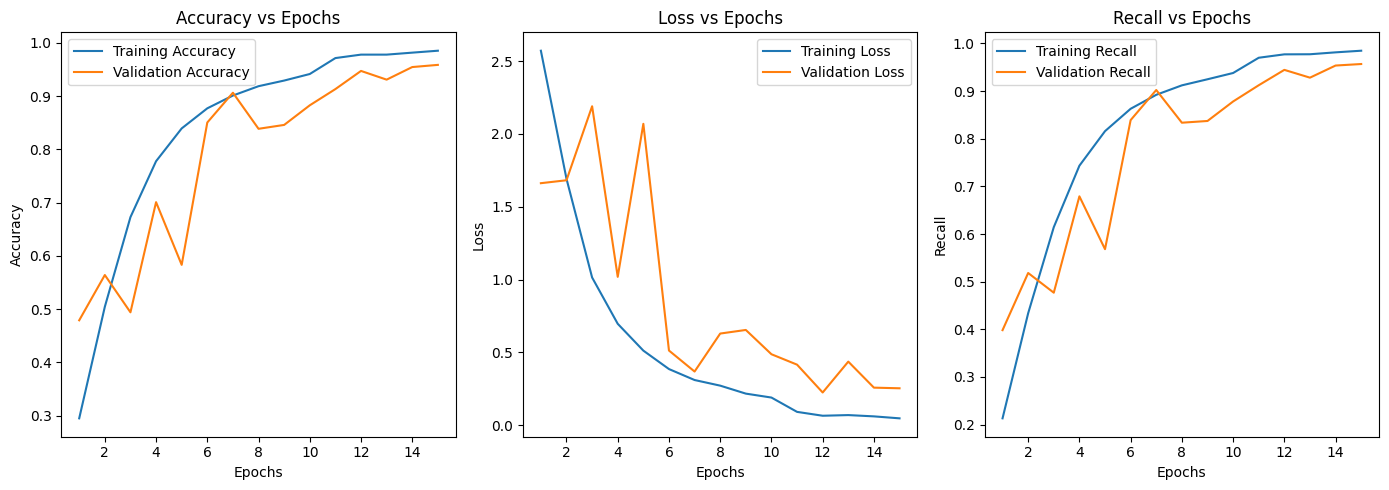

69/69 [==============================] - 1s 8ms/step


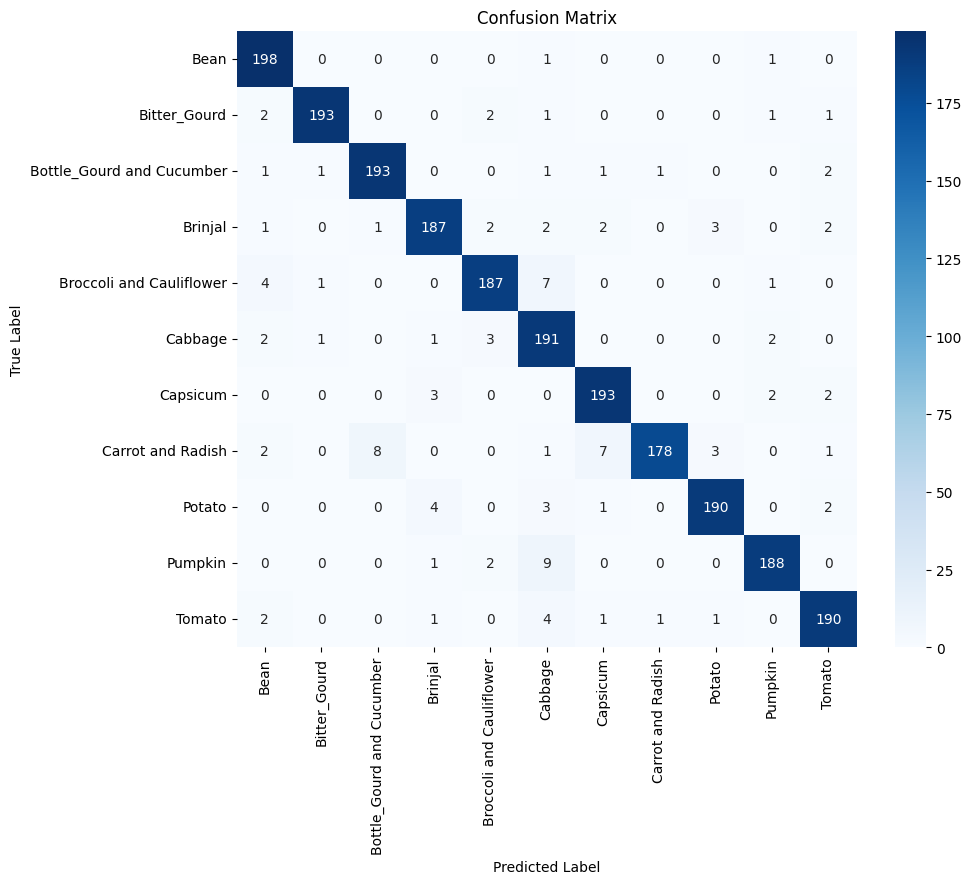

In [49]:
# Load the training history from the pickle file

history_path = best_model_path.replace('.h5', '_history.pkl')
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

evaluate_and_report(best_model, X_test, y_test, labels, input_shape)
print("\nModel Layers:")
for i, layer in enumerate(best_model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")
print()
plot_graph(loaded_history)
plot_confusion_matrix_from_model(best_model, X_test, y_test, labels)


### Best Model Analysis

#### Training and Validation Performance

* **Training Accuracy**: Reaches nearly **98%**
* **Validation Accuracy**: Plateaus around **95%**, indicating a slight generalization gap
* **Training Loss**: Continues to decrease steadily to around **0.1**
* **Validation Loss**: Fluctuates between **0.2–0.4** in later epochs
* **Recall**:

  * Training Recall: **98%**
  * Validation Recall: Drops from **90%** to **85%**, showing **instability**
* **Observation**: Divergence between training and validation metrics suggests **mild overfitting**

---

### Classification Performance

#### Best Performing Classes

| Class        | Accuracy | Correct Predictions |
| ------------ | -------- | ------------------- |
| **Bean**     | **99%**  | 198 / 200           |
| Bottle Gourd | 96.5%    | 193 / 200           |
| Cucumber     | 96.5%    | 193 / 200           |
| Bitter Gourd | 96.5%    | 193 / 200           |
| Capsicum     | 96.5%    | 193 / 200           |

#### Poorest Performing Classes

| Class                  | Accuracy | Correct Predictions |
| ---------------------- | -------- | ------------------- |
| **Carrot & Radish**    | **89%**  | 178 / 200           |
| Broccoli & Cauliflower | 93.5%    | 187 / 200           |
| Brinjal                | 93.5%    | 187 / 200           |

---

#### Key Misclassifications

* **Pumpkin → Cabbage**: 9 instances (most frequent single misclassification)
* **Carrot & Radish → Bottle Gourd / Cucumber**: 8 instances
* **Carrot & Radish → Capsicum**: 7 instances
* **Broccoli & Cauliflower → Cabbage**: 7 instances

#### Cross-Classification Issues

* **Cabbage** receives misclassifications from:

  * Pumpkin: 9
  * Broccoli: 7
  * Tomato: 4
  * Potato: 3
* **Carrot & Radish** are often confused with:

  * Capsicum
  * Bottle Gourd / Cucumber (Likely due to **similar shapes or colors**)

---

#### Overall Summary

* **Overall Accuracy**: **95%** (based on confusion matrix diagonal)
* **Strong Performance**: 8 out of 11 classes have >90% accuracy
* **Training Convergence**: Metrics stabilize after **epoch 10**

---

#### Areas for Improvement

* **Mild Overfitting**:

  * Increase **dropout rate** slightly

* **Poorly Classified Classes**:

  * Augment more training data for **Carrot & Radish**, **Broccoli & Cauliflower**, **Pumpkin** (around 100)
  * Augment some training data for **Cabbage** (around 50)

   If it perform poorly increase or decrease augment data accordingly 


### Improving Best HyperTuned Model (101x101)

In [51]:
# Prepare the data for training
dataset101_aug_tune = dataset101_balanced.copy()
# Augment dataset101_balanced for tuning
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
augmented_rows = []
amt_to_augment = {
    'Carrot and Radish': 100,
    'Broccoli and Cauliflower': 100,
    'Pumpkin': 100,
    'Cabbage': 100
}
for label, amt in amt_to_augment.items():
    label_rows = dataset101_aug_tune[dataset101_aug_tune[label]]
    if len(label_rows) < amt:
        print(f"Not enough samples for {label}. Found {len(label_rows)}, needed {amt}. Skipping augmentation.")
        continue
    for _ in range(amt):
        row = label_rows.sample(n=1).iloc[0]
        image = row['image'].squeeze()
        image = image.reshape((1, image.shape[0], image.shape[1], 1))
        augmented_iter = datagen.flow(image, batch_size=1)
        augmented_image = next(augmented_iter)[0]
        augmented_row = row.copy()
        augmented_row['image'] = augmented_image
        augmented_rows.append(augmented_row)

dataset101_aug_tune = pd.concat([dataset101_aug_tune] + augmented_rows, ignore_index=True)

X_train = np.array([np.squeeze(img) for img in dataset101_aug_tune[dataset101_aug_tune['split'] == 'train']['image']])
y_train = dataset101_aug_tune[dataset101_aug_tune['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset101_aug_tune[dataset101_aug_tune['split'] == 'validation']['image']])
y_val = dataset101_aug_tune[dataset101_aug_tune['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset101_aug_tune[dataset101_aug_tune['split'] == 'test']['image']])
y_test = dataset101_aug_tune[dataset101_aug_tune['split'] == 'test'][labels].values

# Prepare dataset101_balanced for training
input_shape = (101, 101, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 101, 101, 1)
X_val = X_val.reshape(-1, 101, 101, 1)
X_test = X_test.reshape(-1, 101, 101, 1)

In [ ]:
# Build and compile the model
model = create_model(
    input_shape=input_shape,
    num_classes=num_classes,
    conv_filters=[32, 64, 256],  # Fixed conv_filters for tuning],
    kernel_size=[(3, 3), (3, 3), (3, 3)],  # Fixed kernel_size for tuning
    pool_size=[(2, 2), (2, 2), (3,3)],  # Fixed pool_size for tuning
    dense_units=192,
    dropout_rates=[0.05, 0.1, 0.3],
    activation='elu',
    optimizer='rmsprop',
    batch_norm=True,
    learning_rate=0.0002,
    no_of_conv_layers=2,
)

# Convert boolean labels to float32 for Keras compatibility
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
save_model_with_increment(model, test_accuracy, history, "101_models", "best_101_model", X_test, y_test)

Epoch 1/100
5247/5247 [==============================] - 274s 52ms/step - loss: 2.8606 - accuracy: 0.2747 - precision: 0.3465 - recall: 0.2000 - auc: 0.7164 - val_loss: 4.8532 - val_accuracy: 0.3941 - val_precision: 0.4149 - val_recall: 0.3845 - val_auc: 0.7630 - lr: 2.0000e-04
Epoch 2/100
5247/5247 [==============================] - 230s 44ms/step - loss: 2.0013 - accuracy: 0.4611 - precision: 0.5327 - recall: 0.4054 - auc: 0.8493 - val_loss: 1.9974 - val_accuracy: 0.6168 - val_precision: 0.6709 - val_recall: 0.5700 - val_auc: 0.9147 - lr: 2.0000e-04
Epoch 3/100
5247/5247 [==============================] - 269s 51ms/step - loss: 1.4534 - accuracy: 0.6099 - precision: 0.6664 - recall: 0.5714 - auc: 0.9127 - val_loss: 2.9984 - val_accuracy: 0.6664 - val_precision: 0.6852 - val_recall: 0.6400 - val_auc: 0.9092 - lr: 2.0000e-04
Epoch 4/100
5247/5247 [==============================] - 259s 49ms/step - loss: 1.0030 - accuracy: 0.7214 - precision: 0.7615 - recall: 0.6900 - auc: 0.9506 - val_

Test Loss: 0.2540
69/69 [==============================] - 1s 12ms/step
                           precision    recall  f1-score   support

                     Bean       0.93      0.98      0.95       200
             Bitter_Gourd       1.00      0.97      0.98       200
Bottle_Gourd and Cucumber       0.96      0.98      0.97       200
                  Brinjal       0.98      0.94      0.96       200
 Broccoli and Cauliflower       0.92      0.94      0.93       200
                  Cabbage       0.97      0.93      0.95       200
                 Capsicum       0.97      0.98      0.97       200
        Carrot and Radish       0.96      0.94      0.95       200
                   Potato       0.96      0.96      0.96       200
                  Pumpkin       0.98      0.98      0.98       200
                   Tomato       0.97      0.97      0.97       200

                 accuracy                           0.96      2200
                macro avg       0.96      0.96      0.9

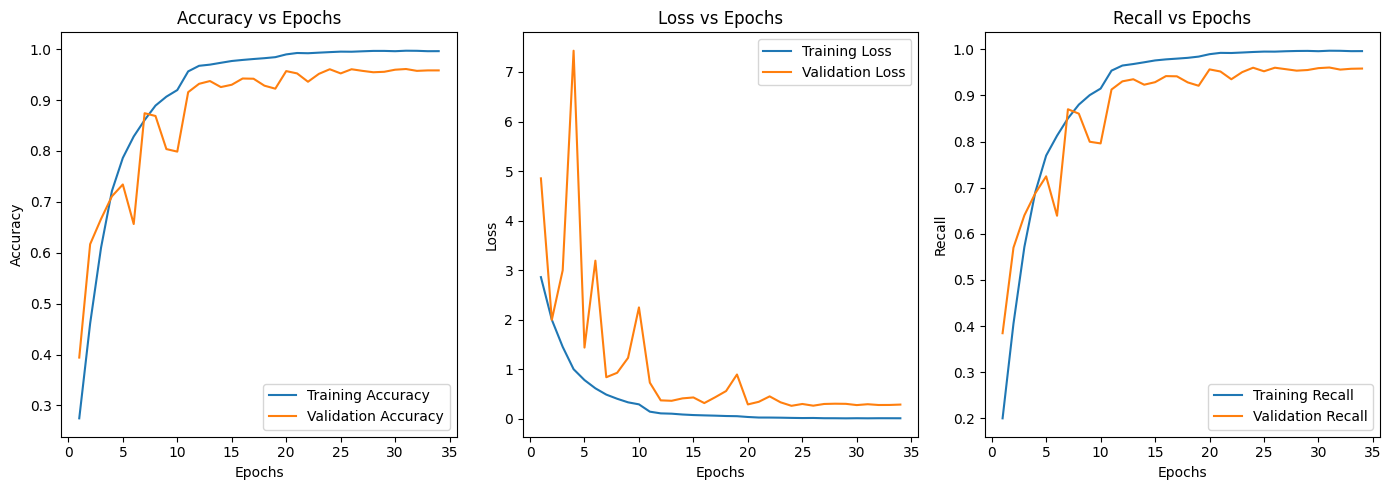

69/69 [==============================] - 1s 11ms/step


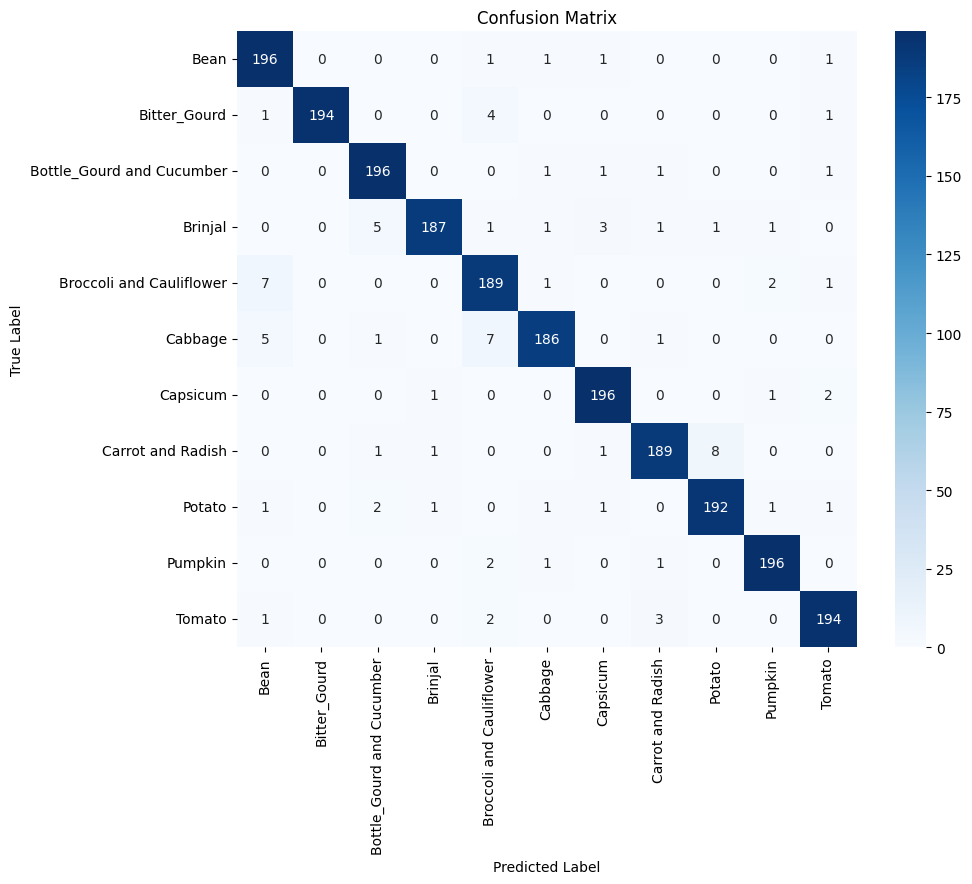

In [57]:
evaluate_and_report(model, X_test, y_test, labels, input_shape)

plot_graph(history)
plot_confusion_matrix_from_model(model, X_test, y_test, labels)

### Image Size (23 by 23)

In [62]:

# Prepare the data for training
# balanced dataset
X_train_bal = np.array([np.squeeze(img) for img in dataset23_balanced[dataset23_balanced['split'] == 'train']['image']])
y_train_bal = dataset23_balanced[dataset23_balanced['split'] == 'train'][labels].values
# Same validation and test data for both dataset
X_val = np.array([np.squeeze(img) for img in dataset23_balanced[dataset23_balanced['split'] == 'validation']['image']])
y_val = dataset23_balanced[dataset23_balanced['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset23_balanced[dataset23_balanced['split'] == 'test']['image']])
y_test = dataset23_balanced[dataset23_balanced['split'] == 'test'][labels].values
# imbalance classes
X_train = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'train']['image']])
y_train = dataset23[dataset23['split'] == 'train'][labels].values

# Prepare dataset23_balanced for training
input_shape = (23, 23, 1)  # Grayscale images of size 23x23
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train_bal = X_train_bal.reshape(-1, 23, 23, 1)

X_train = X_train.reshape(-1, 23, 23, 1)
X_val = X_val.reshape(-1, 23, 23, 1)
X_test = X_test.reshape(-1, 23, 23, 1)

In [ ]:
param_grid = {

    'conv_filters': [
        [4],
        [8],
        [16],
        [32],
        [64],
        [128],
        [258],
        [16, 32],
        [32, 64],
        [16, 32, 64],
        [32, 32],
        [16, 16],
        [8, 16],
        [8, 8],
        [8, 16, 32],
        [16, 32, 48],
        [24, 32],
        [8, 8, 16],
        [24, 24],
        [32, 64, 64],
        [32, 32, 64],
        [16, 16, 32],
        [32, 48],
        [24, 32, 48],
        [16, 24, 32],
        [4, 8],
        [4, 8, 16],
        [6, 12],
        [6, 12, 24],
        [8, 12],
        [4, 6, 12],
        [6, 6, 12],
        [4, 4],
        [4, 6],
        [6, 8, 12]
    ],
    'kernel_size': [
        [(3,3)],
        [(5, 5)],
        [(1, 1)],
        [(3, 3), (3, 3)],
        [(1, 1), (3, 3)],
        [(3, 3), (1, 1)],
        [(1, 1), (1, 1)],
        [(3, 3), (1, 1), (1, 1)],
        [(1, 1), (1, 1), (3, 3)],
        [(1, 1), (3, 3), (1, 1)],
        [(1, 1), (1, 1), (1, 1)],
        [(2, 2), (2, 2)],
        [(1, 1), (2, 2)],
        [(2, 2), (1, 1)],
        [(2, 2), (2, 2), (2, 2)],
        [(1, 1), (2, 2), (2, 2)],
        [(2, 2), (1, 1), (2, 2)],
        [(1, 1), (1, 1), (2, 2)],
        [(2, 2), (2, 2), (1, 1)]
    ],
    'pool_size': [
        [(2, 2)],
        [(3, 3)],
        [(5, 5)],
        [(2, 2), (2, 2)],
        [(3, 3), (2, 2)],
        [(3, 3), (3, 3)],
        [(2, 2), (3, 3)],
        [(2, 2), (2, 2), (2, 2)],
        [(1, 1), (2, 2), (2, 2)],
        [(2, 2), (1, 1), (2, 2)],
        [(2, 2), (2, 2), (1, 1)],
        [(1, 1), (1, 1)],
        [(1, 1), (2, 2)],
        [(2, 2), (1, 1)],
        [(1, 1), (1, 1), (1, 1)],
        [(1, 1), (1, 1), (2, 2)],
        [(2, 2), (1, 1), (1, 1)],
        [(1, 1), (2, 2), (1, 1)]
    ],
    'dropout_rates': [
        [0.25, 0.25, 0.5],
        [0.2, 0.3, 0.4],
        [0.1, 0.2, 0.5],
        [0.2, 0.2, 0.3],
        [0.15, 0.25, 0.5],
        [0.1, 0.3, 0.6],
        [0.05, 0.1, 0.3],
        [0.2, 0.1, 0.4],
        [0.25, 0.2, 0.55],
        [0.1, 0.1, 0.3],
        [0.1, 0.2, 0.25]
    ],
    'dense_units': [
        32, 64, 96, 128, 160, 192, 256, 512
    ],
    'learning_rate': [
        0.001, 0.0005, 0.0001, 0.005, 0.002, 0.0002
    ],
    'batch_size': [
        4, 8, 16, 32, 6, 12
    ],
    'activation': ['relu', 'elu'],
    'optimizer': ['adam', 'rmsprop'],
    'batch_norm': [True, False],
    'no_of_conv_layers': [1, 2],  # Number of Conv2D layers
    'balanced_dataset': [True, False]  # Whether to use a balanced dataset
}
# Settings
num_trials = 20 # Number of random samples

best_model = None
best_accuracy = 0
best_params = None

for i in range(num_trials):
    print(f"\nTrial {i+1}/{num_trials}")

    # Randomly sample hyperparameters
    while True:
        params = {key: random.choice(values) for key, values in param_grid.items()}
        if len(params['conv_filters']) in [2, 3] and len(params['kernel_size']) == len(params['conv_filters']) and len(params['pool_size']) == len(params['conv_filters']):
            break
    print(f"Parameters: {params}")
    try:
        tf.keras.backend.clear_session()
        gc.collect()

        # Check VRAM and RAM usage
        print(f"RAM usage: {psutil.virtual_memory().percent}%")
        # Print GPU memory usage
        physical_devices = tf.config.list_physical_devices('GPU')
        for device in physical_devices:
            device_name = device.name.split(':')[-1]  # Extract the valid device string (e.g., "GPU:0")
            memory_info = tf.config.experimental.get_memory_info(f"GPU:{device_name.split(':')[-1]}")
            print(f"GPU {device_name} memory allocated: {memory_info['current'] / 1024**2} MB")

        # Build and compile the model
        model = create_model(
            input_shape=input_shape,
            num_classes=num_classes,
            conv_filters=params['conv_filters'],
            kernel_size=params['kernel_size'],
            pool_size=params['pool_size'],
            dense_units=params['dense_units'],
            dropout_rates=params['dropout_rates'],
            activation=params['activation'],
            optimizer=params['optimizer'],
            batch_norm=params['batch_norm'],
            learning_rate=params['learning_rate'],
            no_of_conv_layers=params['no_of_conv_layers'],
        )

        if params['balanced_dataset']:
            X_train_trial, y_train_trial = X_train_bal, y_train_bal
        else:
            X_train_trial, y_train_trial = X_train, y_train
        history = model.fit(
            X_train_trial, y_train_trial,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=params['batch_size'],
            verbose=0,
            callbacks=[early_stopping, reduce_lr]
        )

        test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model
            best_params = params
            save_model_with_increment(model, test_accuracy, history, "23_models", "best_23_model", X_test, y_test)
        else:
            print(f"Accuracy {test_accuracy:.4f} did not beat best {best_accuracy:.4f}")

    except Exception as e:
        print(f"Error during training: {e}")
        break

# Final results
print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")


Trial 1/20
Parameters: {'conv_filters': [8, 8], 'kernel_size': [(3, 3), (1, 1)], 'pool_size': [(1, 1), (1, 1)], 'dropout_rates': [0.05, 0.1, 0.3], 'dense_units': 512, 'learning_rate': 0.0002, 'batch_size': 6, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_norm': False, 'no_of_conv_layers': 1, 'balanced_dataset': True}
RAM usage: 95.9%
GPU 0 memory allocated: 50.86865234375 MB
Current model accuracy (0.70) is not better than the best saved model (0.90).

Trial 2/20
Parameters: {'conv_filters': [4, 6, 12], 'kernel_size': [(3, 3), (1, 1), (1, 1)], 'pool_size': [(2, 2), (2, 2), (1, 1)], 'dropout_rates': [0.2, 0.1, 0.4], 'dense_units': 160, 'learning_rate': 0.0005, 'batch_size': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_norm': True, 'no_of_conv_layers': 1, 'balanced_dataset': False}
RAM usage: 94.6%
GPU 0 memory allocated: 48.660400390625 MB
Accuracy 0.6500 did not beat best 0.7041

Trial 3/20
Parameters: {'conv_filters': [4, 6, 12], 'kernel_size': [(1, 1), (3, 3), (1,

Accuracy:0.8268\
Parameters: {'conv_filters': [16, 16, 32], 'kernel_size': [(1, 1), (3, 3), (1, 1)], 'pool_size': [(1, 1), (2, 2), (2, 2)], 'dropout_rates': [0.1, 0.1, 0.3], 'dense_units': 160, 'learning_rate': 0.001, 'batch_size': 16, 'activation': 'elu', 'optimizer': 'rmsprop', 'batch_norm': True, 'kernel_initializer': 'he_normal', 'l2_reg': 0.0001}

Accuracy:0.9005\
Parameters: {'conv_filters': [16, 32, 64], 'kernel_size': [(2, 2), (2, 2), (2, 2)], 'pool_size': [(2, 2), (2, 2), (1, 1)], 'dropout_rates': [0.1, 0.2, 0.5], 'dense_units': 512, 'learning_rate': 0.0002, 'batch_size': 6, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_norm': True, 'no_of_conv_layers': 2, 'balanced_dataset': False}


#### Best 23 Model (Summary & Analysis)

In [63]:
directory = "23_models"  # Directory where models are saved
prefix = "best_23_model"  # Prefix for the model filenames
all_files = os.listdir(directory)
pattern = re.compile(r'^best_23_model-(\d+)\.h5$')
model_versions = [
    int(match.group(1)) for f in all_files if (match := pattern.match(f))
]

# Load the best model
best_version = max(model_versions)
best_model_path = os.path.join(directory, f"{prefix}-{best_version}.h5")
print(best_model_path)
best_model = tf.keras.models.load_model(best_model_path)
# Show model summary
print("\nModel Summary:")
best_model.summary()
# Prepare test data from dataset23
X_test = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'test']['image']])
y_test = dataset23[dataset23['split'] == 'test'][labels].values
X_test = X_test.reshape(-1, 23, 23, 1)

# Evaluate the loaded model
results = best_model.evaluate(X_test, y_test, verbose=0)
test_loss = results[0]
test_accuracy = results[1]
# Display test accuracy
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

23_models\best_23_model-14.h5

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 16)        80        
                                                                 
 batch_normalization (BatchN  (None, 22, 22, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        2080      
                                                                 
 batch_nor

Test Loss: 0.3006
69/69 [==============================] - 0s 3ms/step
                           precision    recall  f1-score   support

                     Bean       0.85      0.94      0.89       200
             Bitter_Gourd       0.93      0.88      0.90       200
Bottle_Gourd and Cucumber       0.92      0.95      0.94       200
                  Brinjal       0.91      0.94      0.93       200
 Broccoli and Cauliflower       0.79      0.82      0.81       200
                  Cabbage       0.93      0.85      0.89       200
                 Capsicum       0.96      0.95      0.96       200
        Carrot and Radish       0.91      0.90      0.90       200
                   Potato       0.93      0.88      0.90       200
                  Pumpkin       0.92      0.93      0.93       200
                   Tomato       0.86      0.86      0.86       200

                 accuracy                           0.90      2200
                macro avg       0.90      0.90      0.90

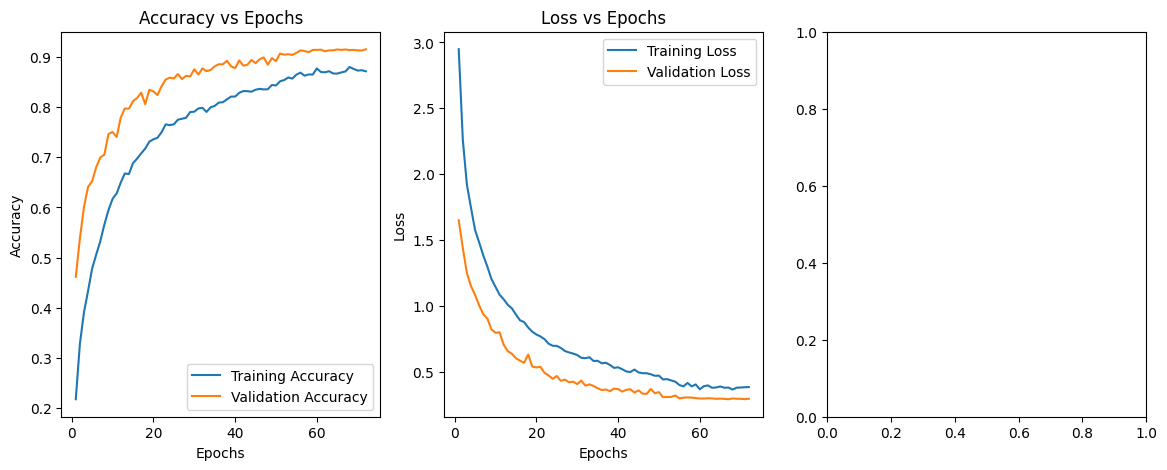

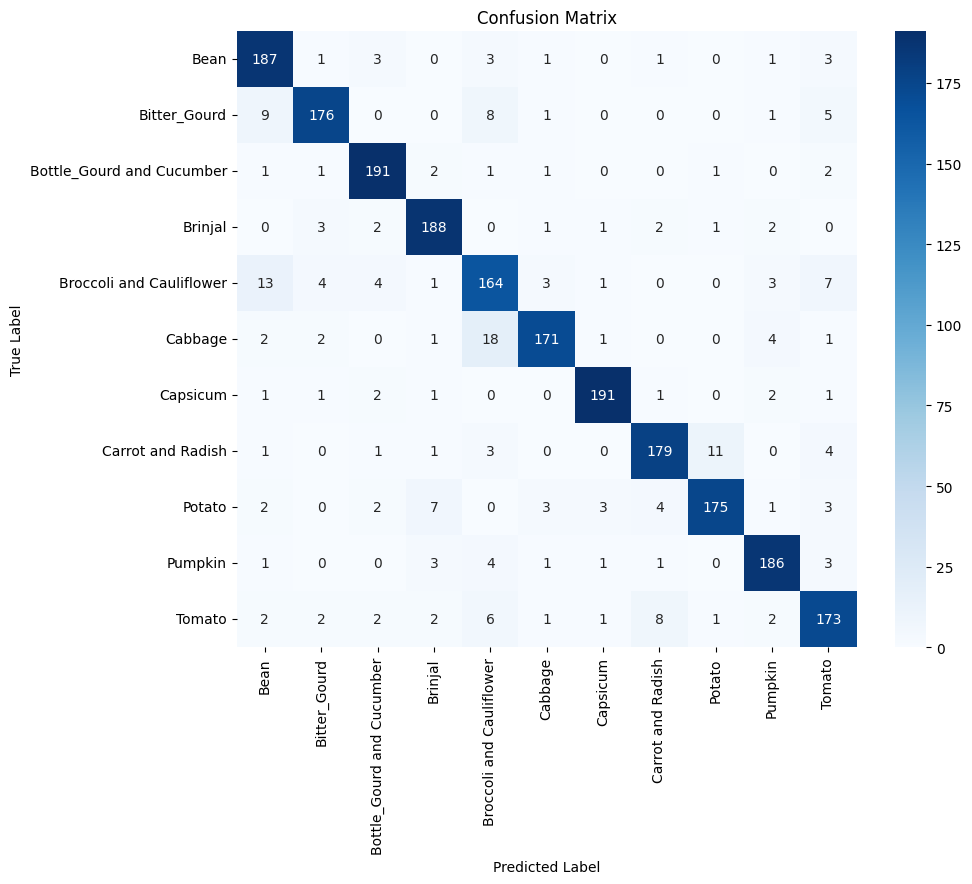

In [64]:
# Load the training history from the pickle file

history_path = best_model_path.replace('.h5', '_history.pkl')
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

evaluate_and_report(best_model, X_test, y_test, labels, input_shape)
print("\nModel Layers:")
for i, layer in enumerate(best_model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")
print()
plot_graph(loaded_history)
plot_confusion_matrix_from_model(best_model, X_test, y_test, labels)


### Best Model Analysis

#### Training and Validation Performance

* **Training Accuracy**: Reaches nearly **87%**
* **Validation Accuracy**: Plateaus around **92%**, indicating a slight generalization gap*
* **Convergence**: Both training and validation curves converge nicely around **20** epochs

* **Observation**: A well-balanced model with no over-fitting and under-fitting

---

### Classification Performance

#### Best Performing Classes

| Class            | Accuracy | Correct Predictions | Most Common Misclassifications                 |
| ---------------- | -------- | ------------------- | ---------------------------------------------- |
| **Potato**       | 87.5%    | 175 / 200           | Carrot/Radish (11), Brinjal (7)                |
| **Bitter Gourd** | 88.0%    | 176 / 200           | Bean (9), Broccoli/Cauliflower (8), Tomato (5) |

#### Poorest Performing Classes

| Class                      | Accuracy  | Correct Predictions | Most Common Misclassifications                            |
| -------------------------- | --------- | ------------------- | --------------------------------------------------------- |
| **Broccoli & Cauliflower** | **82.0%** | 164 / 200           | Bean (13), Tomato (7), Bottle Gourd (4), Bitter Gourd (4) |
| **Cabbage**                | 85.5%     | 171 / 200           | Broccoli/Cauliflower (18), Pumpkin (4)                    |
| **Tomato**                 | 86.5%     | 173 / 200           | Carrot/Radish (8), Broccoli/Cauliflower (6)               |

---

#### Cross-Classification Issues

- Broccoli/Cauliflower ↔ Cabbage (31 total misclassifications)
- Root Vegetable Confusion (Potato ↔ Carrot/Radish)

- Tomato ↔ Round Objects

---

### Performance

* **Overall Model Performance**: Great with \~92% validation accuracy

### Improvement Strategy

#### 1. Data Augmentation

* **Add the most images** (≈200) to:

  * **Broccoli and Cauliflower**, **Bean**

* **Add a moderate amount** (≈150) to:

  * **Cabbage**, **Tomato**, **Carrot and Radish**

* **Add the least amount** (≈100) to:

  * **Bitter\_Gourd**


#### 2. Data Removal

* **Remove the most** (≈25 images) from:

  * **Broccoli** and **Cauliflower**

    *Commonly confused with: **Bean** and **Bitter Gourd**

* **Remove a moderate amount** (≈20 images) from:

  * **Brinjal**

    * Commonly confused with: **Bean**, **Bottle Gourd**, **Cucumber**, **Capsicum**
  * **Cabbage**

    * Commonly confused with: **Broccoli**, **Cauliflower**

* **Remove the least** from:

  * **Tomato** (≈15 images)

    * Confused with: **Carrot and Radish**
  * **Bean** (≈10 images)

---


#### Trying Data Augmentation to Improve Performance

In [94]:
dataset23_aug_tune = dataset23.copy()
# Augment dataset23_aug_tune for tuning
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
augmented_rows = []
amt_to_remove = {
    'Broccoli and Cauliflower': 200,
    'Bean': 200,
    'Cabbage': 150,
    'Tomato': 150,
    'Carrot and Radish': 150,
    'Potato': 150,
    'Bitter_Gourd': 100,
}
for label, amt in amt_to_augment.items():
    label_rows = dataset23_aug_tune[(dataset23_aug_tune[label]) & (dataset23_aug_tune['split'] == 'train')]
    if len(label_rows) < amt:
        print(f"Not enough samples for {label}. Found {len(label_rows)}, needed {amt}. Skipping augmentation.")
        continue
    for _ in range(amt):
        row = label_rows.sample(n=1).iloc[0]
        image = row['image'].squeeze()
        image = image.reshape((1, image.shape[0], image.shape[1], 1))
        augmented_iter = datagen.flow(image, batch_size=1)
        augmented_image = next(augmented_iter)[0]
        augmented_row = row.copy()
        augmented_row['image'] = augmented_image
        augmented_rows.append(augmented_row)

dataset23_aug_tune = pd.concat([dataset23_aug_tune] + augmented_rows, ignore_index=True)

X_train = np.array([np.squeeze(img) for img in dataset23_aug_tune[dataset23_aug_tune['split'] == 'train']['image']])
y_train = dataset23_aug_tune[dataset23_aug_tune['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset23_aug_tune[dataset23_aug_tune['split'] == 'validation']['image']])
y_val = dataset23_aug_tune[dataset23_aug_tune['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset23_aug_tune[dataset23_aug_tune['split'] == 'test']['image']])
y_test = dataset23_aug_tune[dataset23_aug_tune['split'] == 'test'][labels].values

# Prepare dataset23_aug_tune for training
input_shape = (23, 23, 1)  # Grayscale images of size 23x23
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 23, 23, 1)
X_val = X_val.reshape(-1, 23, 23, 1)
X_test = X_test.reshape(-1, 23, 23, 1)

In [95]:
model = create_model(
    input_shape=input_shape,
    num_classes=num_classes,
    conv_filters=[16, 32, 64],  # Fixed conv_filters for tuning],
    kernel_size=[(2, 2), (2, 2), (2, 2)],  # Fixed kernel_size for tuning
    pool_size=[(2, 2), (2, 2), (1, 1)],  # Fixed pool_size for tuning
    dense_units=512,
    dropout_rates=[0.1, 0.2, 0.5],
    activation='relu',
    optimizer='rmsprop',
    batch_norm=True,
    learning_rate=0.0002,
    no_of_conv_layers=2,
)

# Convert boolean labels to float32 for Keras compatibility
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
save_model_with_increment(model, test_accuracy, history, "23_models", "best_23_model", X_test, y_test)

Epoch 1/100
3847/3847 [==============================] - 36s 9ms/step - loss: 2.8764 - accuracy: 0.1755 - precision: 0.2107 - recall: 0.0750 - auc: 0.6354 - val_loss: 1.9756 - val_accuracy: 0.3423 - val_precision: 0.5879 - val_recall: 0.0486 - val_auc: 0.7780 - lr: 2.0000e-04
Epoch 2/100
3847/3847 [==============================] - 32s 8ms/step - loss: 2.3171 - accuracy: 0.2491 - precision: 0.3600 - recall: 0.0989 - auc: 0.7242 - val_loss: 1.8748 - val_accuracy: 0.3745 - val_precision: 0.6008 - val_recall: 0.1286 - val_auc: 0.8100 - lr: 2.0000e-04
Epoch 3/100
3847/3847 [==============================] - 38s 10ms/step - loss: 2.1621 - accuracy: 0.3038 - precision: 0.4194 - recall: 0.1380 - auc: 0.7605 - val_loss: 1.7266 - val_accuracy: 0.4509 - val_precision: 0.6591 - val_recall: 0.1977 - val_auc: 0.8395 - lr: 2.0000e-04
Epoch 4/100
3847/3847 [==============================] - 46s 12ms/step - loss: 2.0420 - accuracy: 0.3426 - precision: 0.4745 - recall: 0.1824 - auc: 0.7909 - val_loss: 

Test Loss: 0.9463
69/69 [==============================] - 0s 2ms/step
                           precision    recall  f1-score   support

                     Bean       0.55      0.76      0.64       200
             Bitter_Gourd       0.80      0.61      0.69       200
Bottle_Gourd and Cucumber       0.68      0.72      0.70       200
                  Brinjal       0.79      0.73      0.76       200
 Broccoli and Cauliflower       0.55      0.55      0.55       200
                  Cabbage       0.73      0.53      0.61       200
                 Capsicum       0.77      0.70      0.73       200
        Carrot and Radish       0.68      0.80      0.74       200
                   Potato       0.71      0.63      0.67       200
                  Pumpkin       0.78      0.83      0.81       200
                   Tomato       0.69      0.77      0.73       200

                 accuracy                           0.69      2200
                macro avg       0.70      0.69      0.69

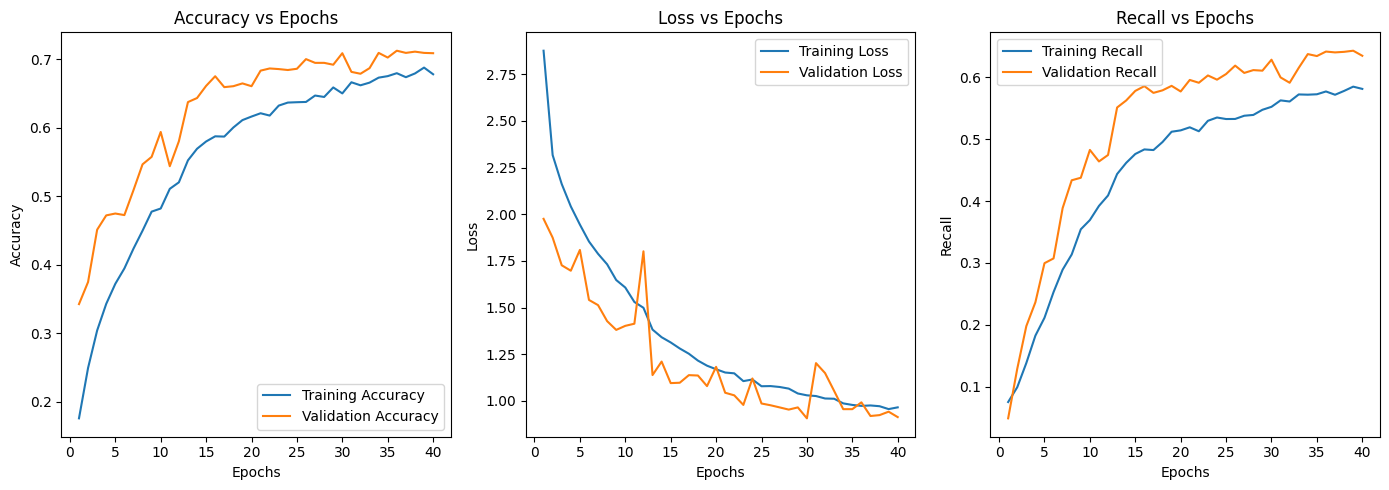

69/69 [==============================] - 0s 2ms/step


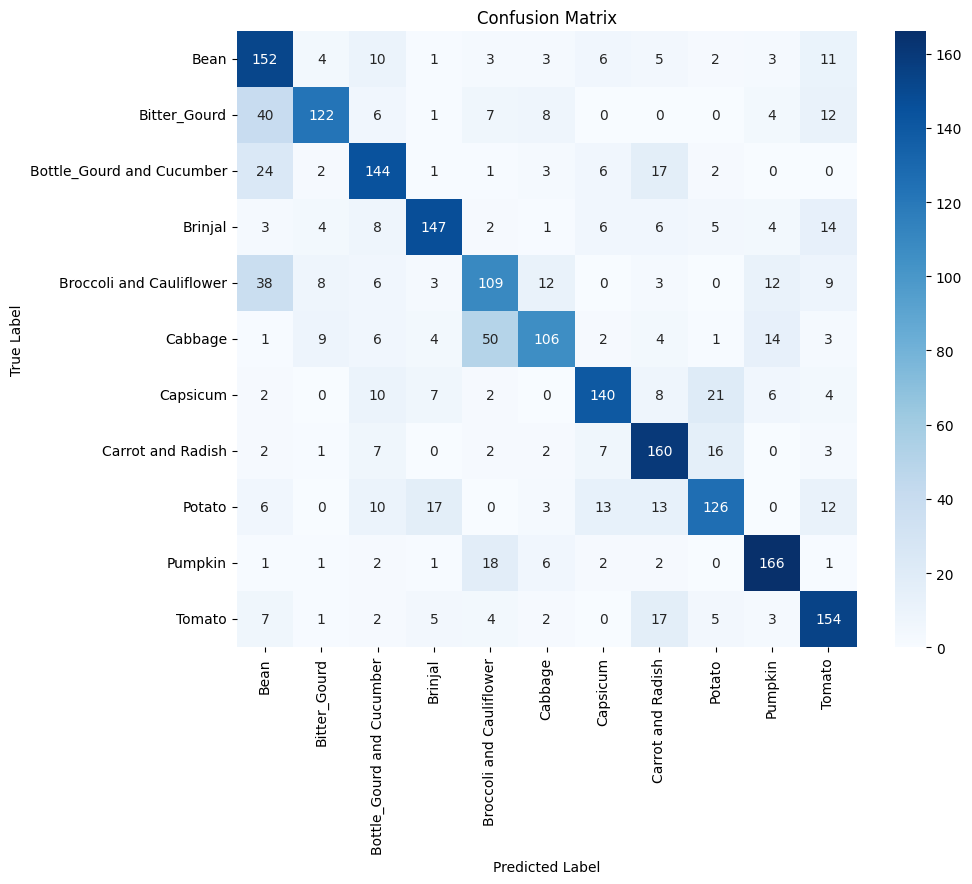

In [96]:
evaluate_and_report(model, X_test, y_test, labels, input_shape)

plot_graph(history)
plot_confusion_matrix_from_model(model, X_test, y_test, labels)

#### Trying Data Removal to Improve Performance

In [97]:
dataset23_filtered = dataset23.copy()
dataset23_filtered['label'] = dataset23_filtered[labels].idxmax(axis=1)

def get_top_similar_indices(target_class, confusing_classes, top_n):
    target_imgs = dataset23_filtered[(dataset23_filtered['label'] == target_class) & dataset23_filtered['split'] == "train"].copy()
    confusing_imgs = dataset23_filtered[dataset23_filtered['label'].isin(confusing_classes)].copy()

    # Flatten images for MSE comparison
    target_imgs['flat_image'] = target_imgs['image'].apply(lambda x: x.flatten())
    confusing_flat = np.array([img.flatten() for img in confusing_imgs['image']])

    similarity_scores = []
    for idx, row in target_imgs.iterrows():
        target_flat = row['flat_image']
        # Compute average similarity (inverse of distance)
        mse_scores = [mean_squared_error(target_flat, other) for other in confusing_flat]
        avg_mse = np.mean(mse_scores)
        similarity_scores.append((idx, avg_mse))

    # Sort by most similar (lowest avg MSE)
    similarity_scores.sort(key=lambda x: x[1])
    top_indices = [idx for idx, _ in similarity_scores[:top_n]]
    return top_indices

# Define removal plan with confusion classes
removal_plan = {
    'Broccoli and Cauliflower': {
        'confused_with': ['Bean', 'Bitter_Gourd'],
        'remove_count': 25
    },
    'Brinjal': {
        'confused_with': ['Bean', 'Bottle_Gourd', 'Cucumber', 'Capsicum'],
        'remove_count': 18
    },
    'Cabbage': {
        'confused_with': ['Broccoli and Cauliflower'],
        'remove_count': 18
    },
    'Tomato': {
        'confused_with': ['Carrot and Radish'],
        'remove_count': 13
    },
    'Bean': {
        'confused_with': [],  # Random
        'remove_count': 8
    }
}

rows_to_remove = []

for cls, info in removal_plan.items():
    if cls == 'Bean':
        # Random removal
        bean_subset = dataset23_filtered[(dataset23_filtered['label'] == cls)& (dataset23_filtered['split'] == 'train')]
        random_indices = bean_subset.sample(n=info['remove_count'], random_state=42).index.tolist()
        rows_to_remove.extend(random_indices)
    else:
        # Similarity-based removal
        top_similar = get_top_similar_indices(cls, info['confused_with'], info['remove_count'])
        rows_to_remove.extend(top_similar)

# Drop the selected ambiguous images
dataset23_filtered = dataset23_filtered.drop(index=rows_to_remove).reset_index(drop=True)
dataset23_filtered.drop(columns=['label'], inplace=True)

# Prepare arrays
X_train = np.array([np.squeeze(img) for img in dataset23_filtered[dataset23_filtered['split'] == 'train']['image']])
y_train = dataset23_filtered[dataset23_filtered['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset23_filtered[dataset23_filtered['split'] == 'validation']['image']])
y_val = dataset23_filtered[dataset23_filtered['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset23_filtered[dataset23_filtered['split'] == 'test']['image']])
y_test = dataset23_filtered[dataset23_filtered['split'] == 'test'][labels].values

# Reshape
X_train = X_train.reshape(-1, 23, 23, 1)
X_val = X_val.reshape(-1, 23, 23, 1)
X_test = X_test.reshape(-1, 23, 23, 1)

In [98]:
model = create_model(
    input_shape=input_shape,
    num_classes=num_classes,
    conv_filters=[16, 32, 64],  # Fixed conv_filters for tuning],
    kernel_size=[(2, 2), (2, 2), (2, 2)],  # Fixed kernel_size for tuning
    pool_size=[(2, 2), (2, 2), (1, 1)],  # Fixed pool_size for tuning
    dense_units=512,
    dropout_rates=[0.1, 0.2, 0.5],
    activation='relu',
    optimizer='rmsprop',
    batch_norm=True,
    learning_rate=0.0002,
    no_of_conv_layers=2,
)

# Convert boolean labels to float32 for Keras compatibility
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
save_model_with_increment(model, test_accuracy, history, "23_models", "best_23_model", X_test, y_test)

Epoch 1/100
3843/3843 [==============================] - 90s 23ms/step - loss: 2.8648 - accuracy: 0.1943 - precision: 0.2295 - recall: 0.0938 - auc: 0.6560 - val_loss: 1.9564 - val_accuracy: 0.3532 - val_precision: 0.5212 - val_recall: 0.1118 - val_auc: 0.7932 - lr: 2.0000e-04
Epoch 2/100
3843/3843 [==============================] - 34s 9ms/step - loss: 2.3251 - accuracy: 0.2653 - precision: 0.3552 - recall: 0.1176 - auc: 0.7347 - val_loss: 1.8879 - val_accuracy: 0.3864 - val_precision: 0.5697 - val_recall: 0.1709 - val_auc: 0.8120 - lr: 2.0000e-04
Epoch 3/100
3843/3843 [==============================] - 35s 9ms/step - loss: 2.1489 - accuracy: 0.3222 - precision: 0.4286 - recall: 0.1671 - auc: 0.7717 - val_loss: 1.8816 - val_accuracy: 0.4450 - val_precision: 0.6282 - val_recall: 0.1982 - val_auc: 0.8362 - lr: 2.0000e-04
Epoch 4/100
3843/3843 [==============================] - 38s 10ms/step - loss: 2.0249 - accuracy: 0.3482 - precision: 0.4768 - recall: 0.2036 - auc: 0.7975 - val_loss: 

Test Loss: 0.7964
69/69 [==============================] - 0s 3ms/step
                           precision    recall  f1-score   support

                     Bean       0.69      0.78      0.73       200
             Bitter_Gourd       0.85      0.69      0.76       200
Bottle_Gourd and Cucumber       0.69      0.81      0.74       200
                  Brinjal       0.76      0.81      0.78       200
 Broccoli and Cauliflower       0.64      0.64      0.64       200
                  Cabbage       0.71      0.69      0.70       200
                 Capsicum       0.86      0.76      0.80       200
        Carrot and Radish       0.79      0.76      0.77       200
                   Potato       0.77      0.60      0.67       200
                  Pumpkin       0.74      0.86      0.79       200
                   Tomato       0.72      0.78      0.75       200

                 accuracy                           0.74      2200
                macro avg       0.75      0.74      0.74

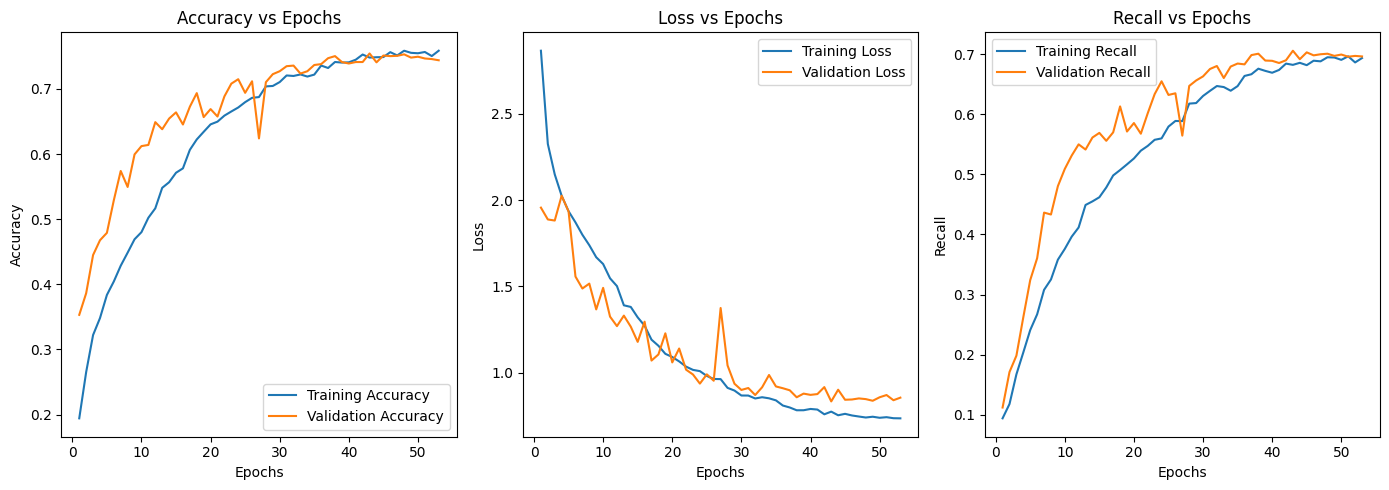

69/69 [==============================] - 0s 2ms/step


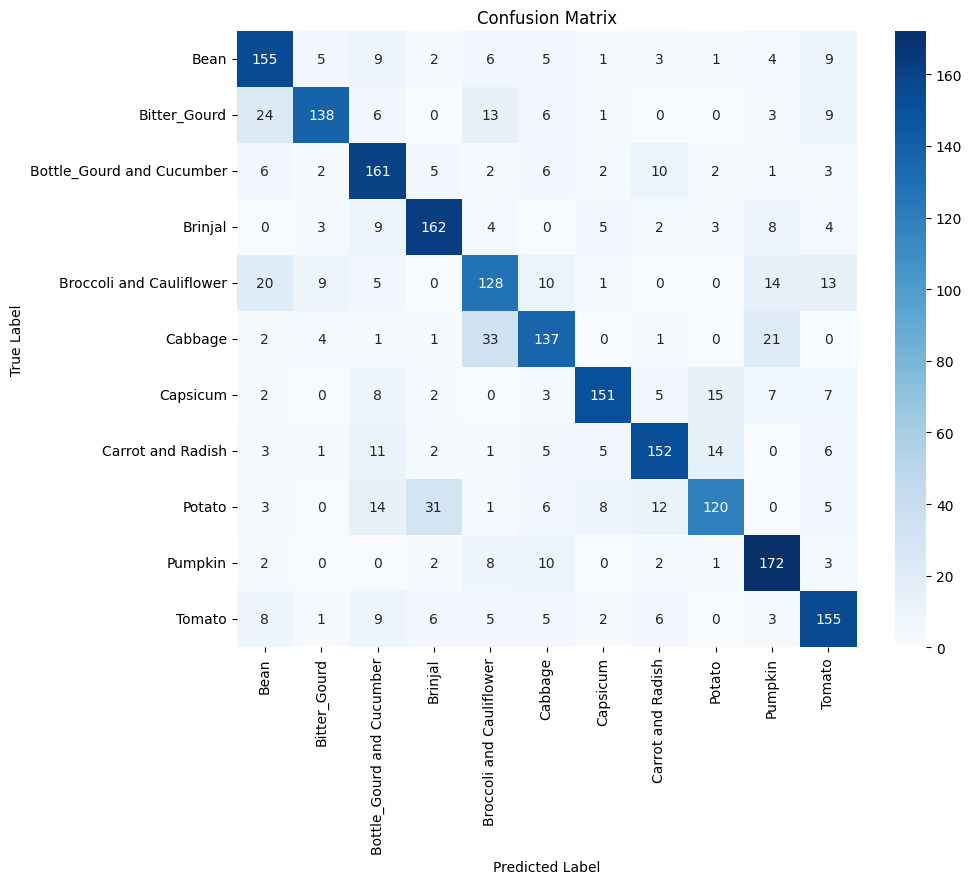

In [99]:
evaluate_and_report(model, X_test, y_test, labels, input_shape)

plot_graph(history)
plot_confusion_matrix_from_model(model, X_test, y_test, labels)

### Observation

After applying both **Data Augmentation** and **Data Removal** strategies to improve my **23x23 model**, the results were **not as expected** — instead of improving performance, the changes actually **made the model worse**.


## Final Best Model
---
### 101 by 101 Model

In [91]:

X_test = np.array([np.squeeze(img) for img in dataset101_balanced[dataset101_balanced['split'] == 'test']['image']])
y_test = dataset101_balanced[dataset101_balanced['split'] == 'test'][labels].values

# Prepare dataset101_balanced for training
input_shape = (101, 101, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_test = X_test.reshape(-1, 101, 101, 1)


directory = "101_models"  # Directory where models are saved
prefix = "best_101_model"  # Prefix for the model filenames
all_files = os.listdir(directory)
pattern = re.compile(r'^best_101_model-(\d+)\.h5$')
model_versions = [
    int(match.group(1)) for f in all_files if (match := pattern.match(f))
]
# print(matching_files)
# Load the best model
best_version = max(model_versions)
best_model_path = os.path.join(directory, f"{prefix}-{best_version}.h5")
best_model = tf.keras.models.load_model(best_model_path)
# Show model summary
print("\nModel Summary:")
best_model.summary()
# Prepare test data from dataset101
X_test = np.array([np.squeeze(img) for img in dataset101[dataset101['split'] == 'test']['image']])
y_test = dataset101[dataset101['split'] == 'test'][labels].values
X_test = X_test.reshape(-1, 101, 101, 1)

# Evaluate the loaded model
results = best_model.evaluate(X_test, y_test, verbose=0)
test_loss = results[0]
test_accuracy = results[1]
# Display test accuracy
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


Model Summary:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 99, 99, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 99, 99, 32)        9248      
                                                                 
 batch_normalization_12 (Bat  (None, 99, 99, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 49

Test Loss: 0.2540
69/69 [==============================] - 1s 12ms/step
                           precision    recall  f1-score   support

                     Bean       0.93      0.98      0.95       200
             Bitter_Gourd       1.00      0.97      0.98       200
Bottle_Gourd and Cucumber       0.96      0.98      0.97       200
                  Brinjal       0.98      0.94      0.96       200
 Broccoli and Cauliflower       0.92      0.94      0.93       200
                  Cabbage       0.97      0.93      0.95       200
                 Capsicum       0.97      0.98      0.97       200
        Carrot and Radish       0.96      0.94      0.95       200
                   Potato       0.96      0.96      0.96       200
                  Pumpkin       0.98      0.98      0.98       200
                   Tomato       0.97      0.97      0.97       200

                 accuracy                           0.96      2200
                macro avg       0.96      0.96      0.9

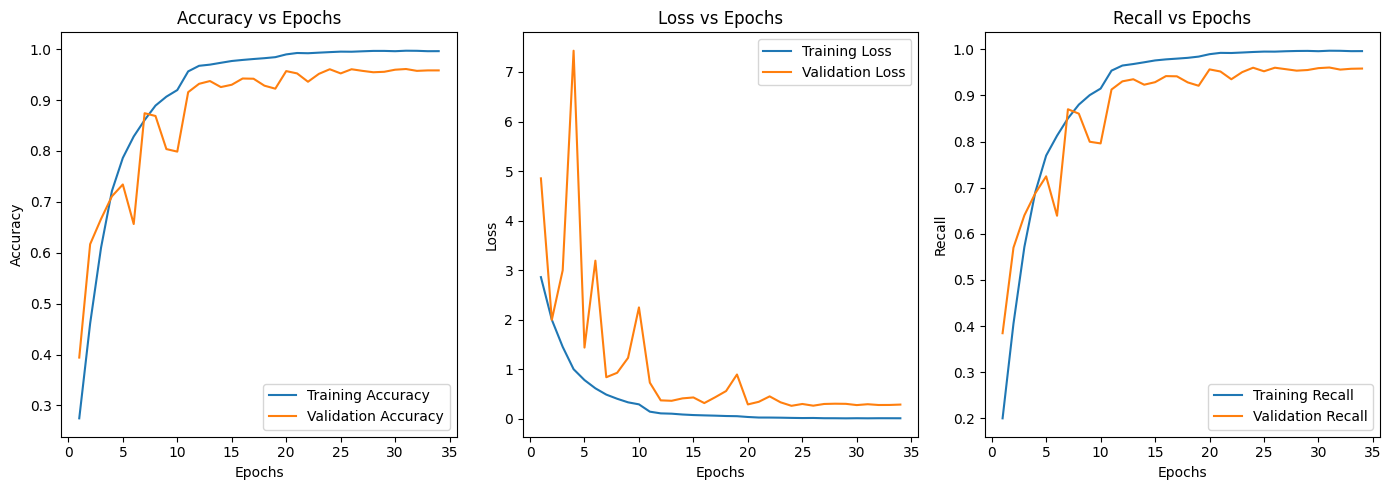

69/69 [==============================] - 1s 12ms/step


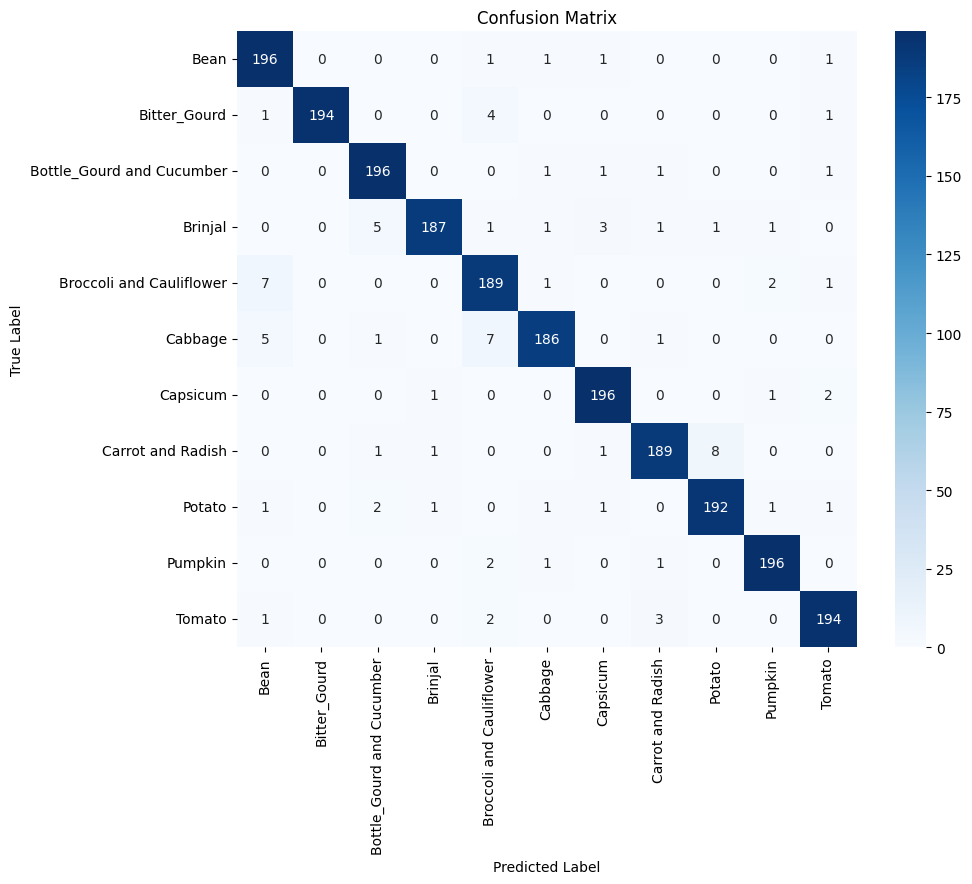

In [92]:
# Load the training history from the pickle file

history_path = best_model_path.replace('.h5', '_history.pkl')
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

evaluate_and_report(best_model, X_test, y_test, labels, input_shape)
print("\nModel Layers:")
for i, layer in enumerate(best_model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")
print()
plot_graph(loaded_history)
plot_confusion_matrix_from_model(best_model, X_test, y_test, labels)

### 23 by 23 Model

In [88]:

X_test = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'test']['image']])
y_test = dataset23[dataset23['split'] == 'test'][labels].values
# Prepare dataset23 for training
input_shape = (23, 23, 1)  # Grayscale images of size 23x23
num_classes = len(labels)

X_test = X_test.reshape(-1, 23, 23, 1)

directory = "23_models"  # Directory where models are saved
prefix = "best_23_model"  # Prefix for the model filenames
all_files = os.listdir(directory)
pattern = re.compile(r'^best_23_model-(\d+)\.h5$')
model_versions = [
    int(match.group(1)) for f in all_files if (match := pattern.match(f))
]

# Load the best model
best_version = max(model_versions)
best_model_path = os.path.join(directory, f"{prefix}-{best_version}.h5")
print(best_model_path)
best_model = tf.keras.models.load_model(best_model_path)
# Show model summary
print("\nModel Summary:")
best_model.summary()
# Prepare test data from dataset23
X_test = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'test']['image']])
y_test = dataset23[dataset23['split'] == 'test'][labels].values
X_test = X_test.reshape(-1, 23, 23, 1)

# Evaluate the loaded model
results = best_model.evaluate(X_test, y_test, verbose=0)
test_loss = results[0]
test_accuracy = results[1]
# Display test accuracy
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

23_models\best_23_model-14.h5

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 16)        80        
                                                                 
 batch_normalization (BatchN  (None, 22, 22, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        2080      
                                                                 
 batch_nor

Test Loss: 0.3006
69/69 [==============================] - 0s 3ms/step
                           precision    recall  f1-score   support

                     Bean       0.85      0.94      0.89       200
             Bitter_Gourd       0.93      0.88      0.90       200
Bottle_Gourd and Cucumber       0.92      0.95      0.94       200
                  Brinjal       0.91      0.94      0.93       200
 Broccoli and Cauliflower       0.79      0.82      0.81       200
                  Cabbage       0.93      0.85      0.89       200
                 Capsicum       0.96      0.95      0.96       200
        Carrot and Radish       0.91      0.90      0.90       200
                   Potato       0.93      0.88      0.90       200
                  Pumpkin       0.92      0.93      0.93       200
                   Tomato       0.86      0.86      0.86       200

                 accuracy                           0.90      2200
                macro avg       0.90      0.90      0.90

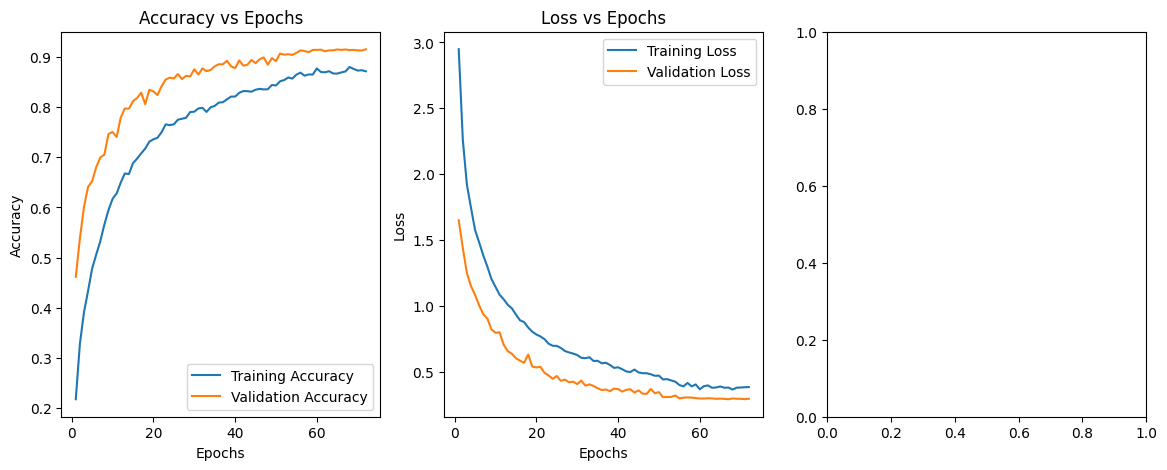

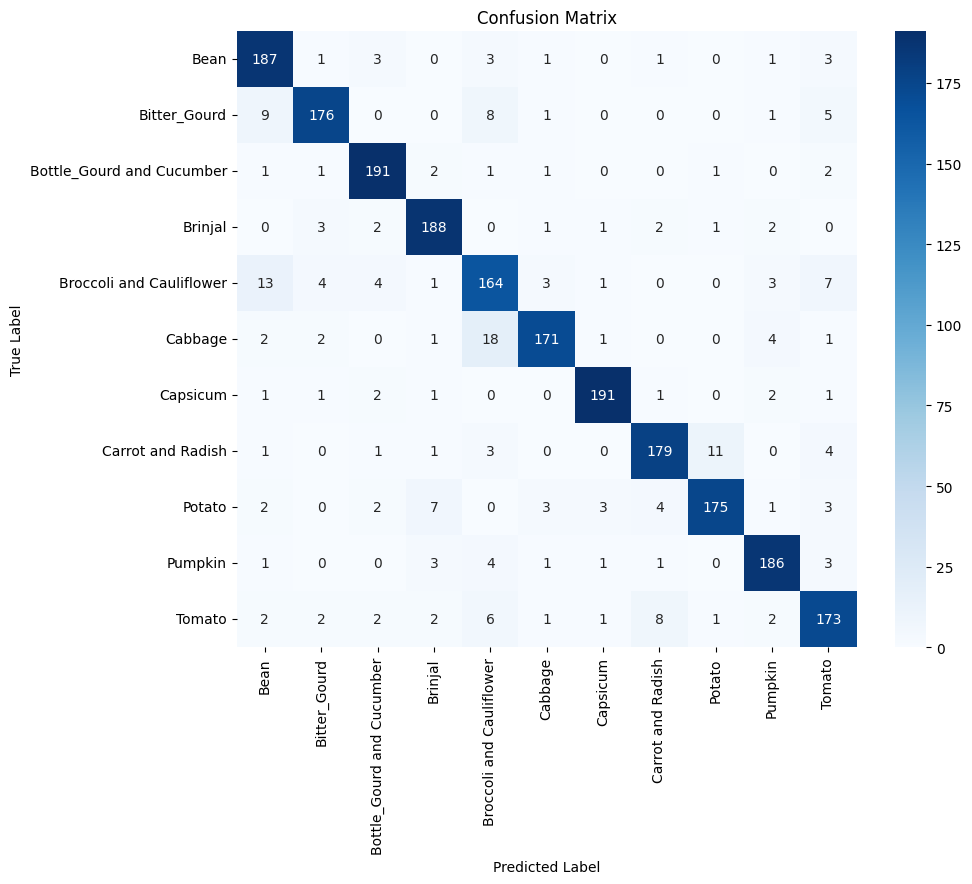

In [89]:
# Load the training history from the pickle file

history_path = best_model_path.replace('.h5', '_history.pkl')
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

evaluate_and_report(best_model, X_test, y_test, labels, input_shape)
print("\nModel Layers:")
for i, layer in enumerate(best_model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")
print()
plot_graph(loaded_history)
plot_confusion_matrix_from_model(best_model, X_test, y_test, labels)

## Conclusion

- The **101x101 model** (96% accuracy) significantly outperformed the **23x23 model** (90% accuracy). This performance difference is likely due to the resolution of the input images.
- The **23x23 images** may contain too few pixels to preserve meaningful details during data augmentation.
- As a result, the visual differences between vegetables are less, making them harder to predict correctly.
- In contrast, **101x101 images** retain enough detail even after augmentation, helping the model to better differentiate between similar-looking vegetables.

### Misclassification Summary

#### 101x101 Model:

* Misclassified **broccoli and cauliflower as bean**: 7 times
* Misclassified **cabbage as bean**: 5 times
* Misclassified **cabbage as broccoli/cauliflower**: 7 times

#### 23x23 Model:

* Misclassified **broccoli and cauliflower as bean**: 13 times
* Misclassified **cabbage as broccoli/cauliflower**: 18 times
* Misclassified **bitter gourd as bean**: 9 times
* Misclassified **bitter gourd as broccoli/cauliflower**: 8 times
* Misclassified **carrot and radish as potato**: 11 times
* Misclassified **tomato as carrot and radish**: 8 times

---
